In [5]:
import matplotlib
import scanpy as sc 
matplotlib.rcParams['font.family'] = 'Arial'

## PCA-free Bias Effect Analysis 

In [49]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')

# --- 데이터 준비 함수 (기존 동일) ---
def prepare_data(adata, layer=None, n_hvg=1000):
    tmp = adata.copy()
    if layer is not None and layer != 'X':
        tmp.X = tmp.layers[layer].copy()
    if hasattr(tmp.X, 'toarray'):
        tmp.X.data = np.nan_to_num(tmp.X.data, nan=0, posinf=0, neginf=0)
    else:
        tmp.X = np.nan_to_num(tmp.X, nan=0, posinf=0, neginf=0)
    sc.pp.filter_genes(tmp, min_cells=1)
    n_curr = tmp.n_vars
    actual_hvg = min(n_hvg, n_curr - 1)
    if actual_hvg > 50:
        sc.pp.highly_variable_genes(tmp, n_top_genes=actual_hvg, flavor='seurat')
        tmp = tmp[:, tmp.var['highly_variable']].copy()
    return tmp

# --- [1] 공분산 구조 (Color 인자 추가) ---
def analyze_covariance_structure(adata, bias_key, n_perms=30, ax=None, color='gray'):
    X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
    b_vals = pd.to_numeric(adata.obs[bias_key], errors='coerce').fillna(0)
    mask = b_vals <= np.median(b_vals)
    
    def get_dist(data_a, data_b):
        c1 = np.cov(StandardScaler().fit_transform(data_a), rowvar=False) + np.eye(data_a.shape[1])*1e-5
        c2 = np.cov(StandardScaler().fit_transform(data_b), rowvar=False) + np.eye(data_b.shape[1])*1e-5
        evals = linalg.eigvalsh(c1, c2)
        return np.sqrt(np.sum(np.log(np.maximum(evals, 1e-9))**2))
        
    if np.sum(mask) < 2 or np.sum(~mask) < 2: return 0.0, 1.0

    obs_dist = get_dist(X[mask], X[~mask])
    null_dists = []
    for _ in range(n_perms):
        idx = np.random.permutation(len(X))
        split = len(X) // 2
        null_dists.append(get_dist(X[idx[:split]], X[idx[split:]]))
    
    pval = (np.sum(np.array(null_dists) >= obs_dist) + 1) / (n_perms + 1)
    
    if ax:
        sns.histplot(null_dists, color=color, stat='density', kde=True, ax=ax, alpha=0.5)
        ax.axvline(obs_dist, color='red', linestyle='--', linewidth=2, label=f'Obs: {obs_dist:.2f}')
        ax.set_title(f"Covariance Dist (p={pval:.3f})")
        ax.legend(fontsize='small')
        ax.grid(alpha=0.1)

    return obs_dist, pval

# --- [2] 상호작용 왜곡 (Color 인자 추가) ---
def analyze_interaction_distortion(adata, bias_key, phenotype_key, ax=None, color='skyblue'):
    X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
    y = pd.factorize(adata.obs[phenotype_key])[0]
    b = pd.to_numeric(adata.obs[bias_key], errors='coerce').fillna(0).values
    design = sm.add_constant(np.column_stack([y, b, y * b]))
    
    p_values = []
    for i in range(X.shape[1]):
        try:
            est = sm.OLS(X[:, i], design).fit()
            p_values.append(est.pvalues[3])
        except: p_values.append(1.0)
            
    p_values = np.array(p_values)
    sig_ratio = np.mean(p_values < 0.05) * 100
    
    if ax:
        sns.histplot(p_values, bins=20, color=color, ax=ax, alpha=0.6)
        ax.axvline(0.05, color='red', linestyle='--', label='p=0.05', linewidth=2)
        ax.set_title(f"Interaction Sig Genes: {sig_ratio:.1f}%")
        ax.set_xlabel("P-value")
        ax.grid(alpha=0.1)

    return sig_ratio

# --- [3] 효과 안정성 (Color 인자 추가) ---
def analyze_effect_stability(adata, bias_key, phenotype_key, n_perms=30, ax=None, color='green'):
    X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
    b_raw = pd.to_numeric(adata.obs[bias_key], errors='coerce').fillna(0).values
    y = pd.factorize(adata.obs[phenotype_key])[0]
    def calc_score(bias_vals):
        try: 
            bins = pd.qcut(bias_vals, q=4, labels=False, duplicates='drop')
        except: return 0.0
        effects = []
        for k in np.unique(bins):
            m = (bins == k)
            # Phenotype의 두 그룹이 모두 존재해야 효과 벡터 계산 가능
            if np.sum(m & (y==1)) > 1 and np.sum(m & (y==0)) > 1:
                vec = np.mean(X[m & (y==1)], axis=0) - np.mean(X[m & (y==0)], axis=0)
                effects.append(vec)
        
        if len(effects) < 2: return np.nan
        sim = cosine_similarity(effects)
        return np.mean(sim[np.triu_indices(len(sim), k=1)])
    obs_score = calc_score(b_raw)
    null_scores = []
    for _ in range(n_perms):
        null_scores.append(calc_score(np.random.permutation(b_raw)))
    null_scores = np.array([s for s in null_scores if not np.isnan(s)])
    if len(null_scores) == 0 or np.isnan(obs_score):
        return np.nan, 1.0
    # obs가 null의 하위 분포에 속할수록(낮을수록) 유의미한 이질성 존재
    pval_hetero = (np.sum(null_scores <= obs_score) + 1) / (len(null_scores) + 1)
    if ax:
        sns.histplot(null_scores, color=color, stat='density', kde=True, ax=ax, alpha=0.5)
        ax.axvline(obs_score, color='red', linestyle='-', linewidth=2, label=f'Obs: {obs_score:.2f}')
        ax.set_title(f"Heterogeneity Test\n(Lower Score = More Distorted, p={pval_hetero:.3f})")
        ax.legend(fontsize='small', loc='upper left')
        
    return obs_score, pval_hetero

In [50]:
adata = sc.read_h5ad("./Data/RPM/Processed/Complete_Normalized_Data.h5ad")
layer_list = list(adata.layers.keys())
layer_list.remove("counts")
bias_list = ['log1p_total_counts', 'orig_gc_bias_score', 'orig_len_bias_score', 'orig_platelet_score']
adata_sub = adata[(adata.obs['Seq_ID'] == 'RPMseq14')|(adata.obs['RPM_NC_label'].notna()), :]
phenotype = 'Type'

>>> Processing 14 Layers...


Layers:   0%|          | 0/14 [00:00<?, ?it/s]

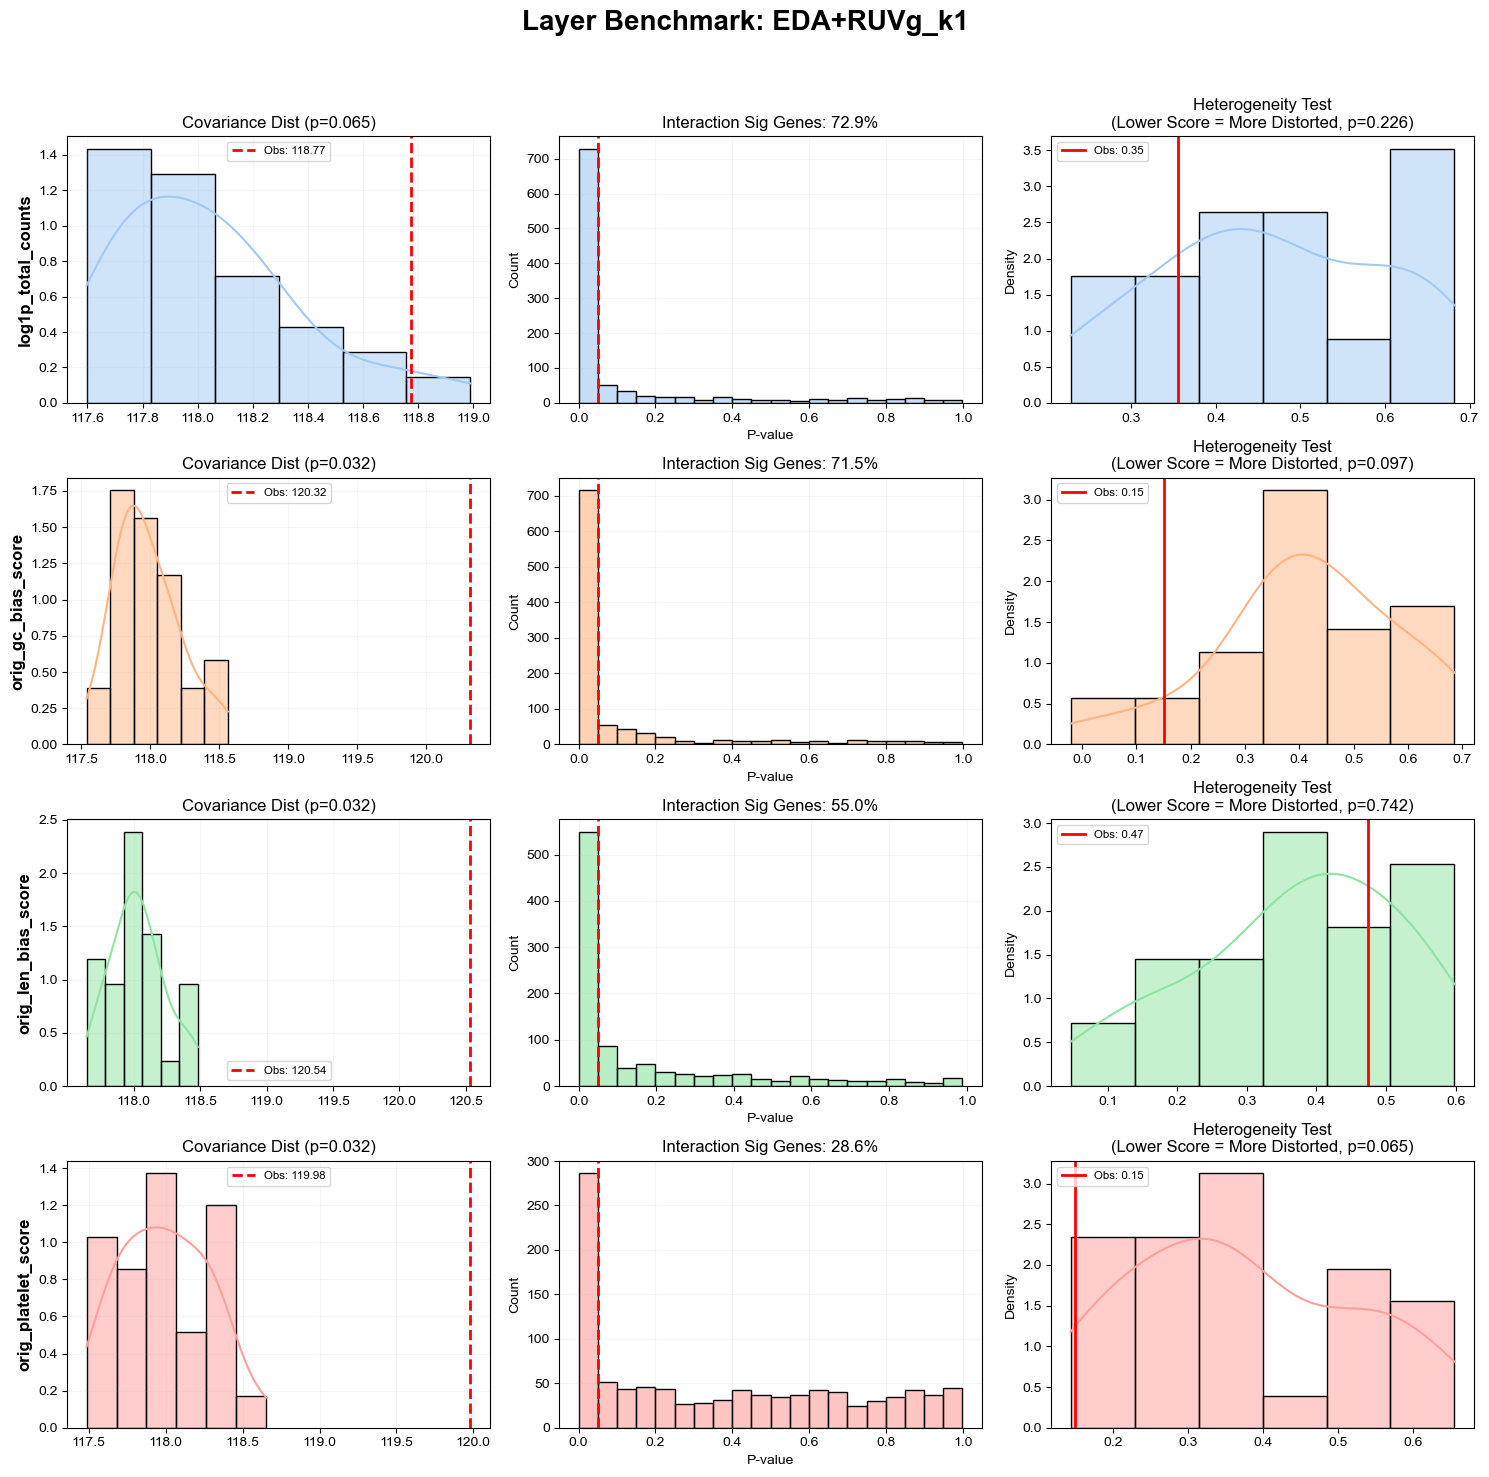

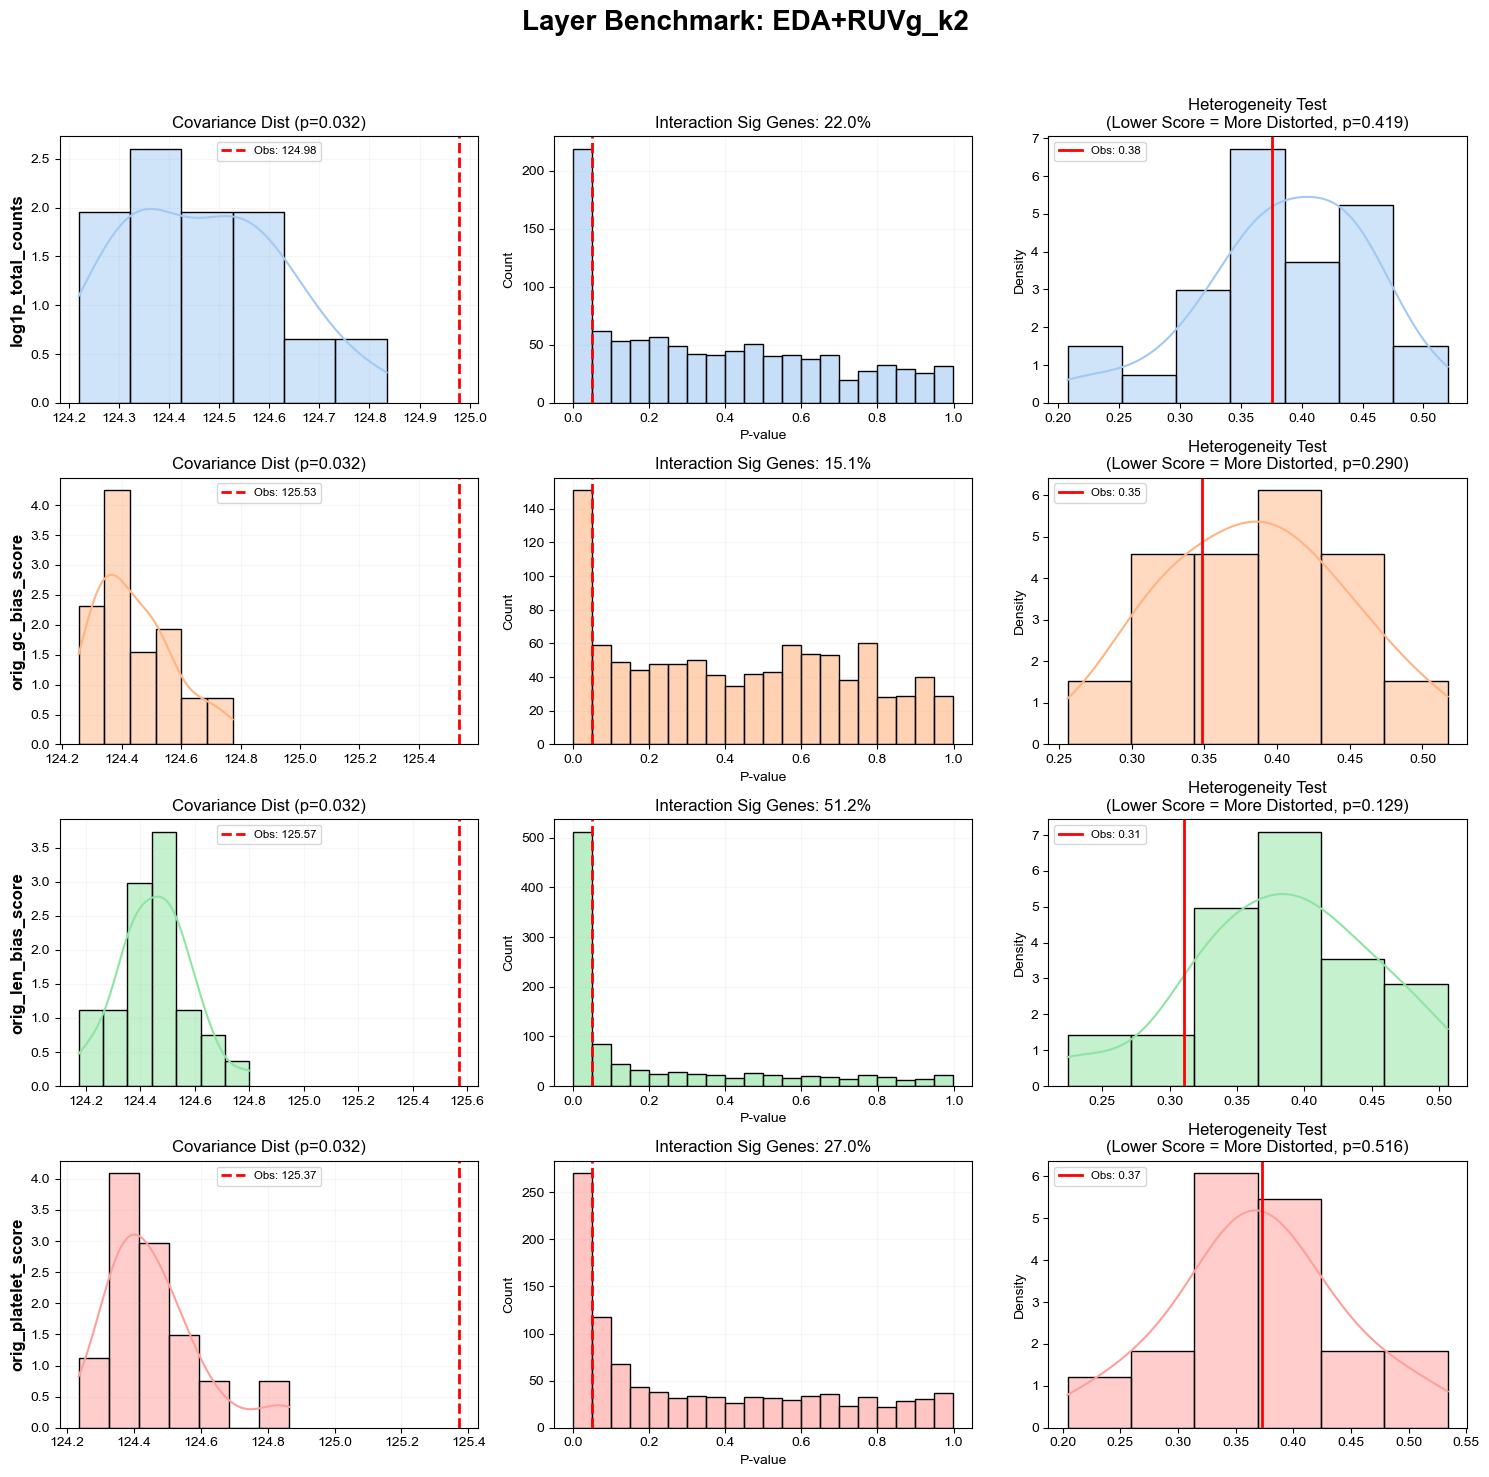

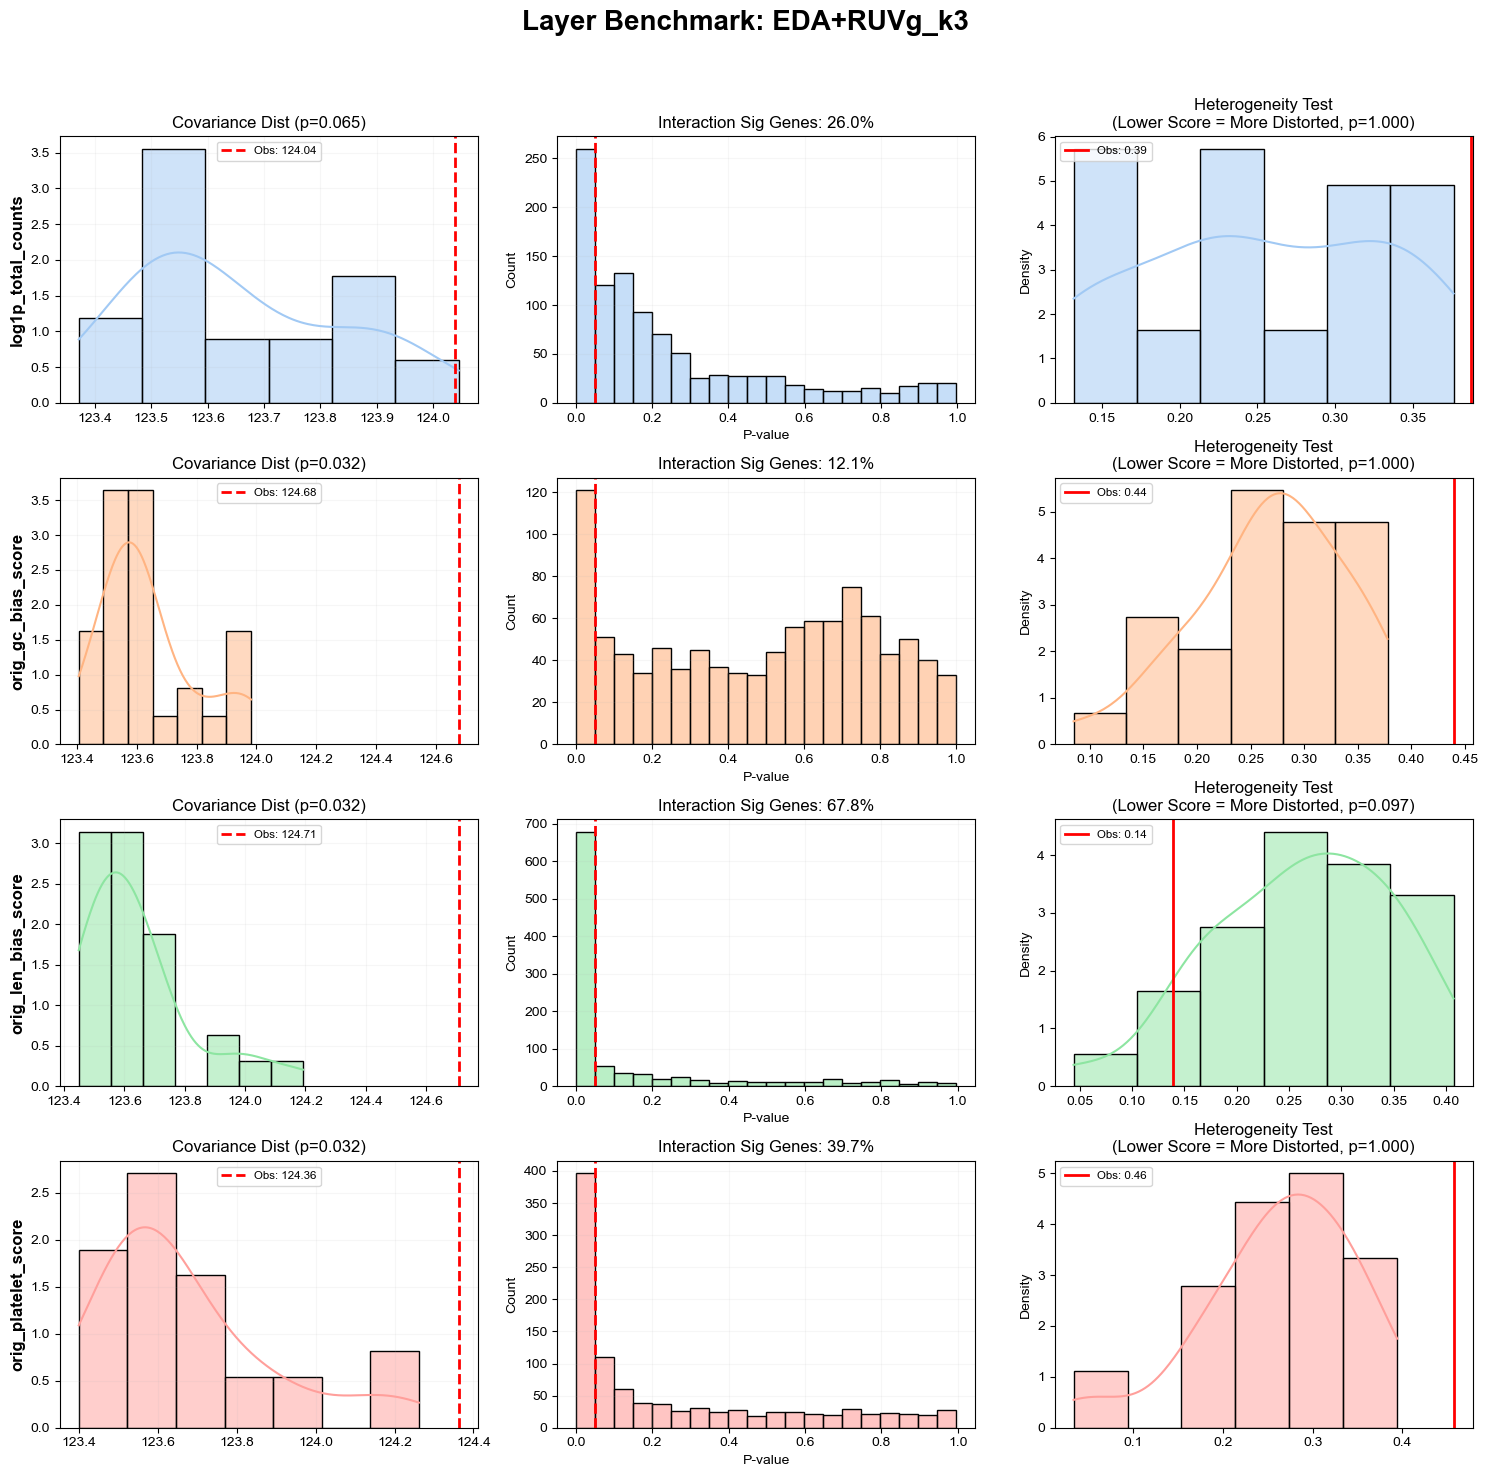

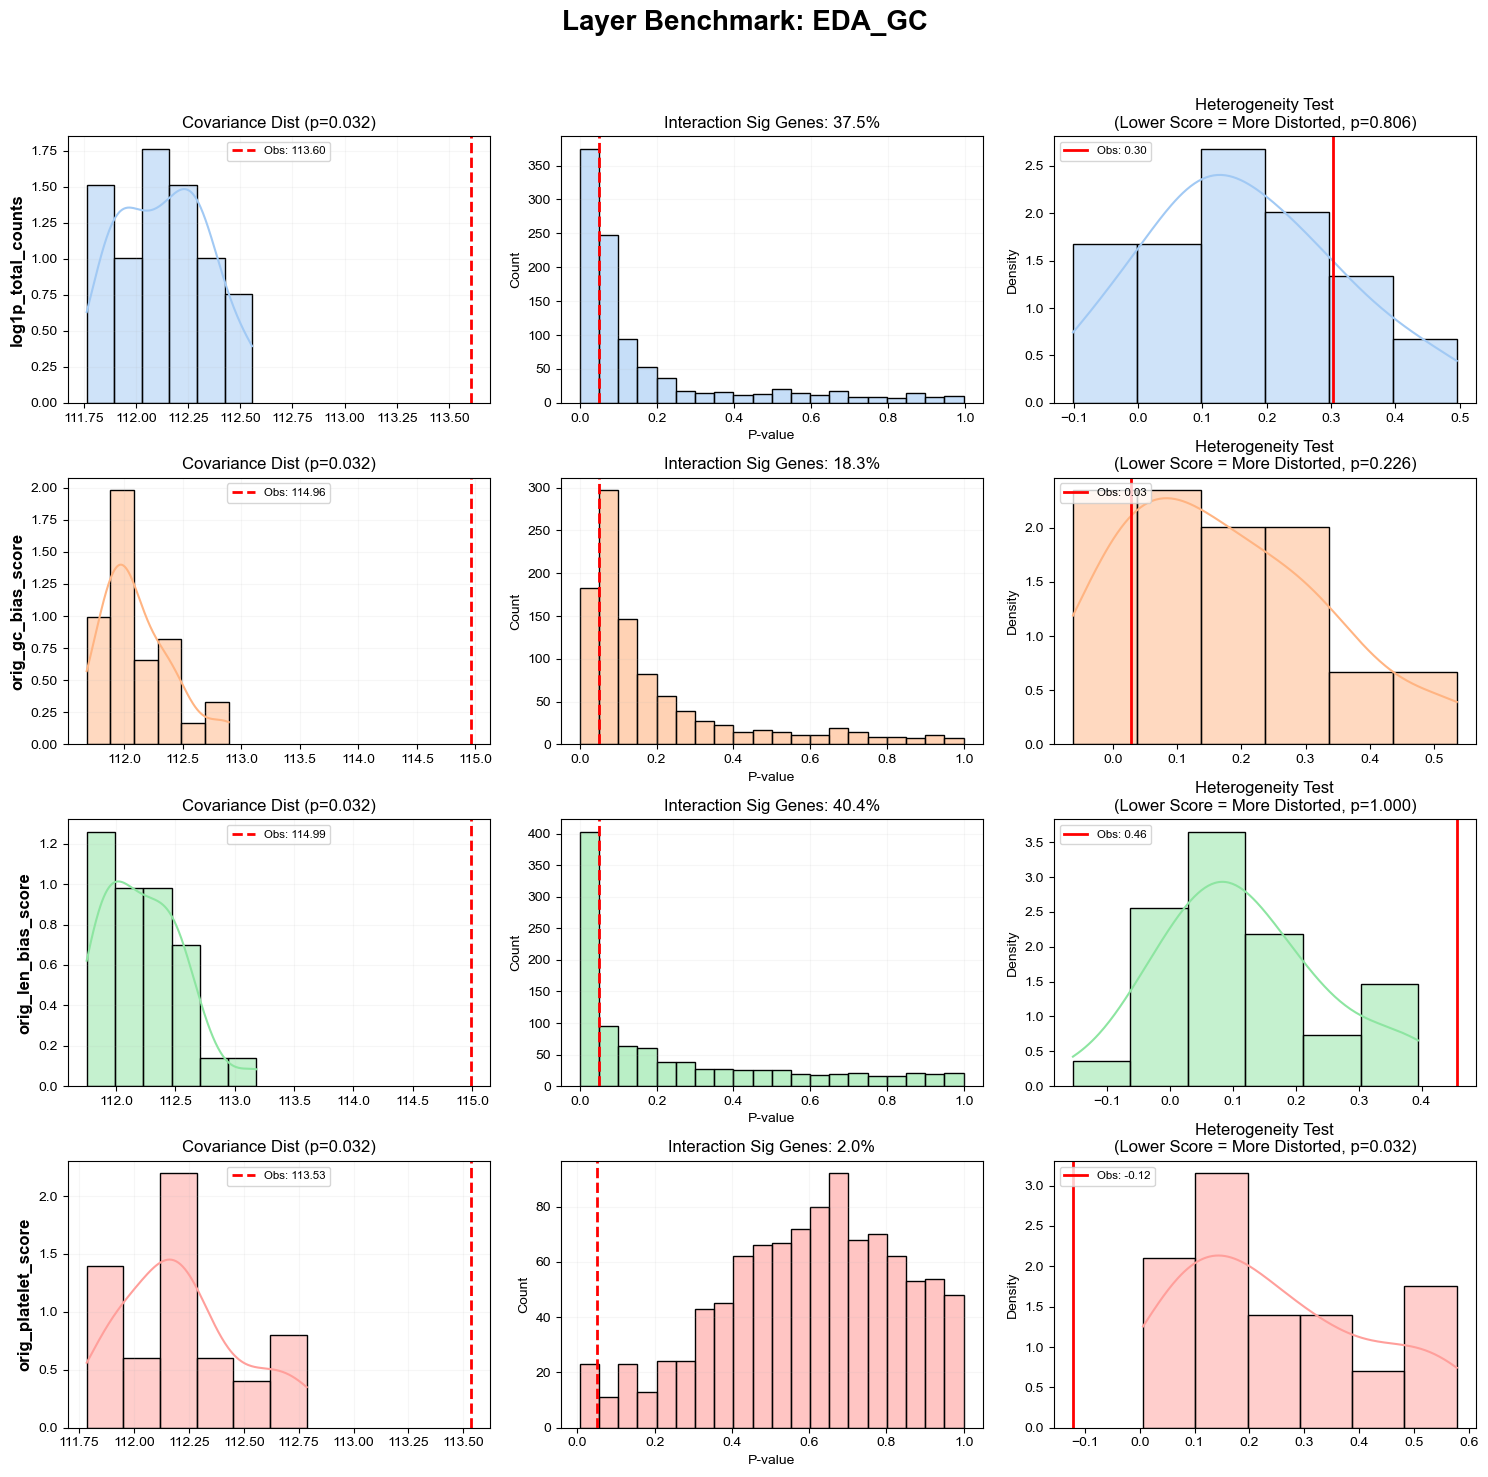

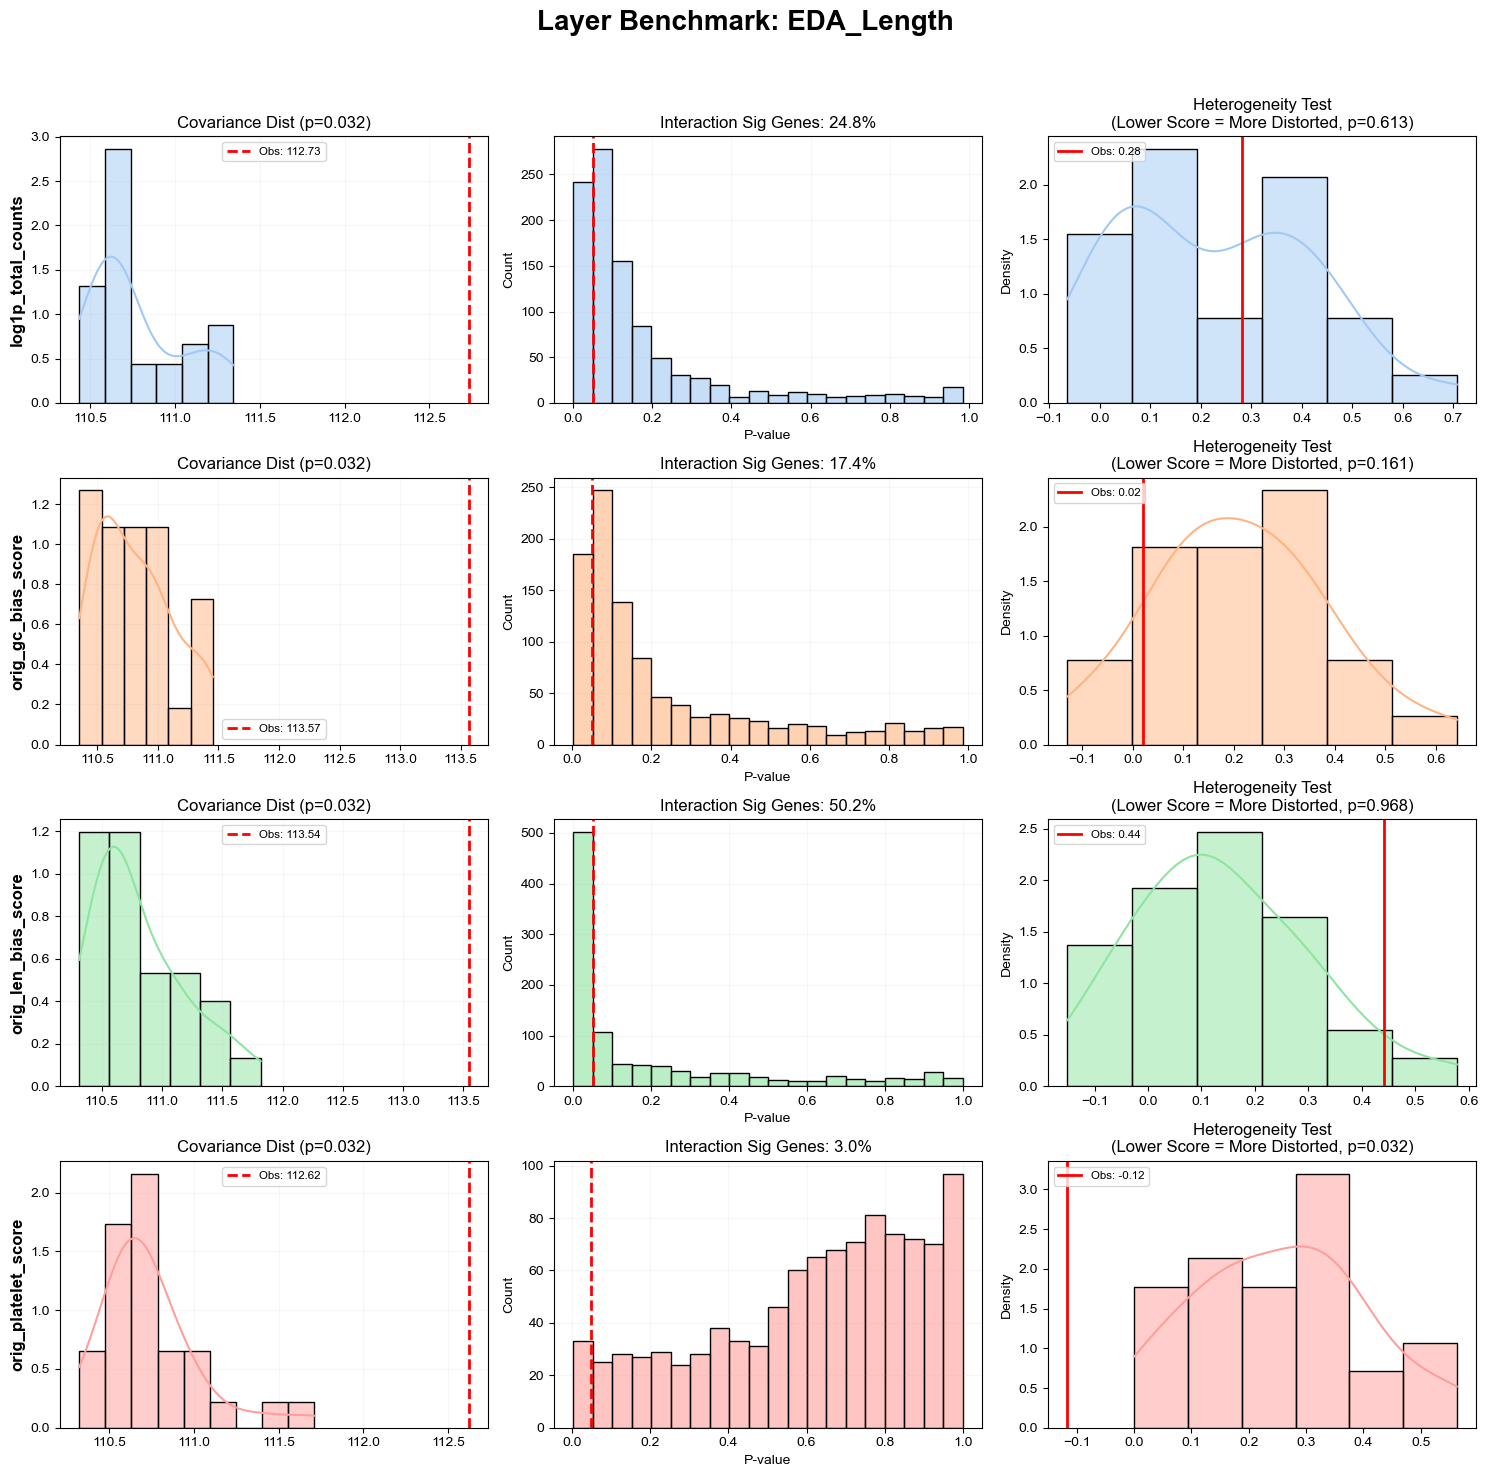

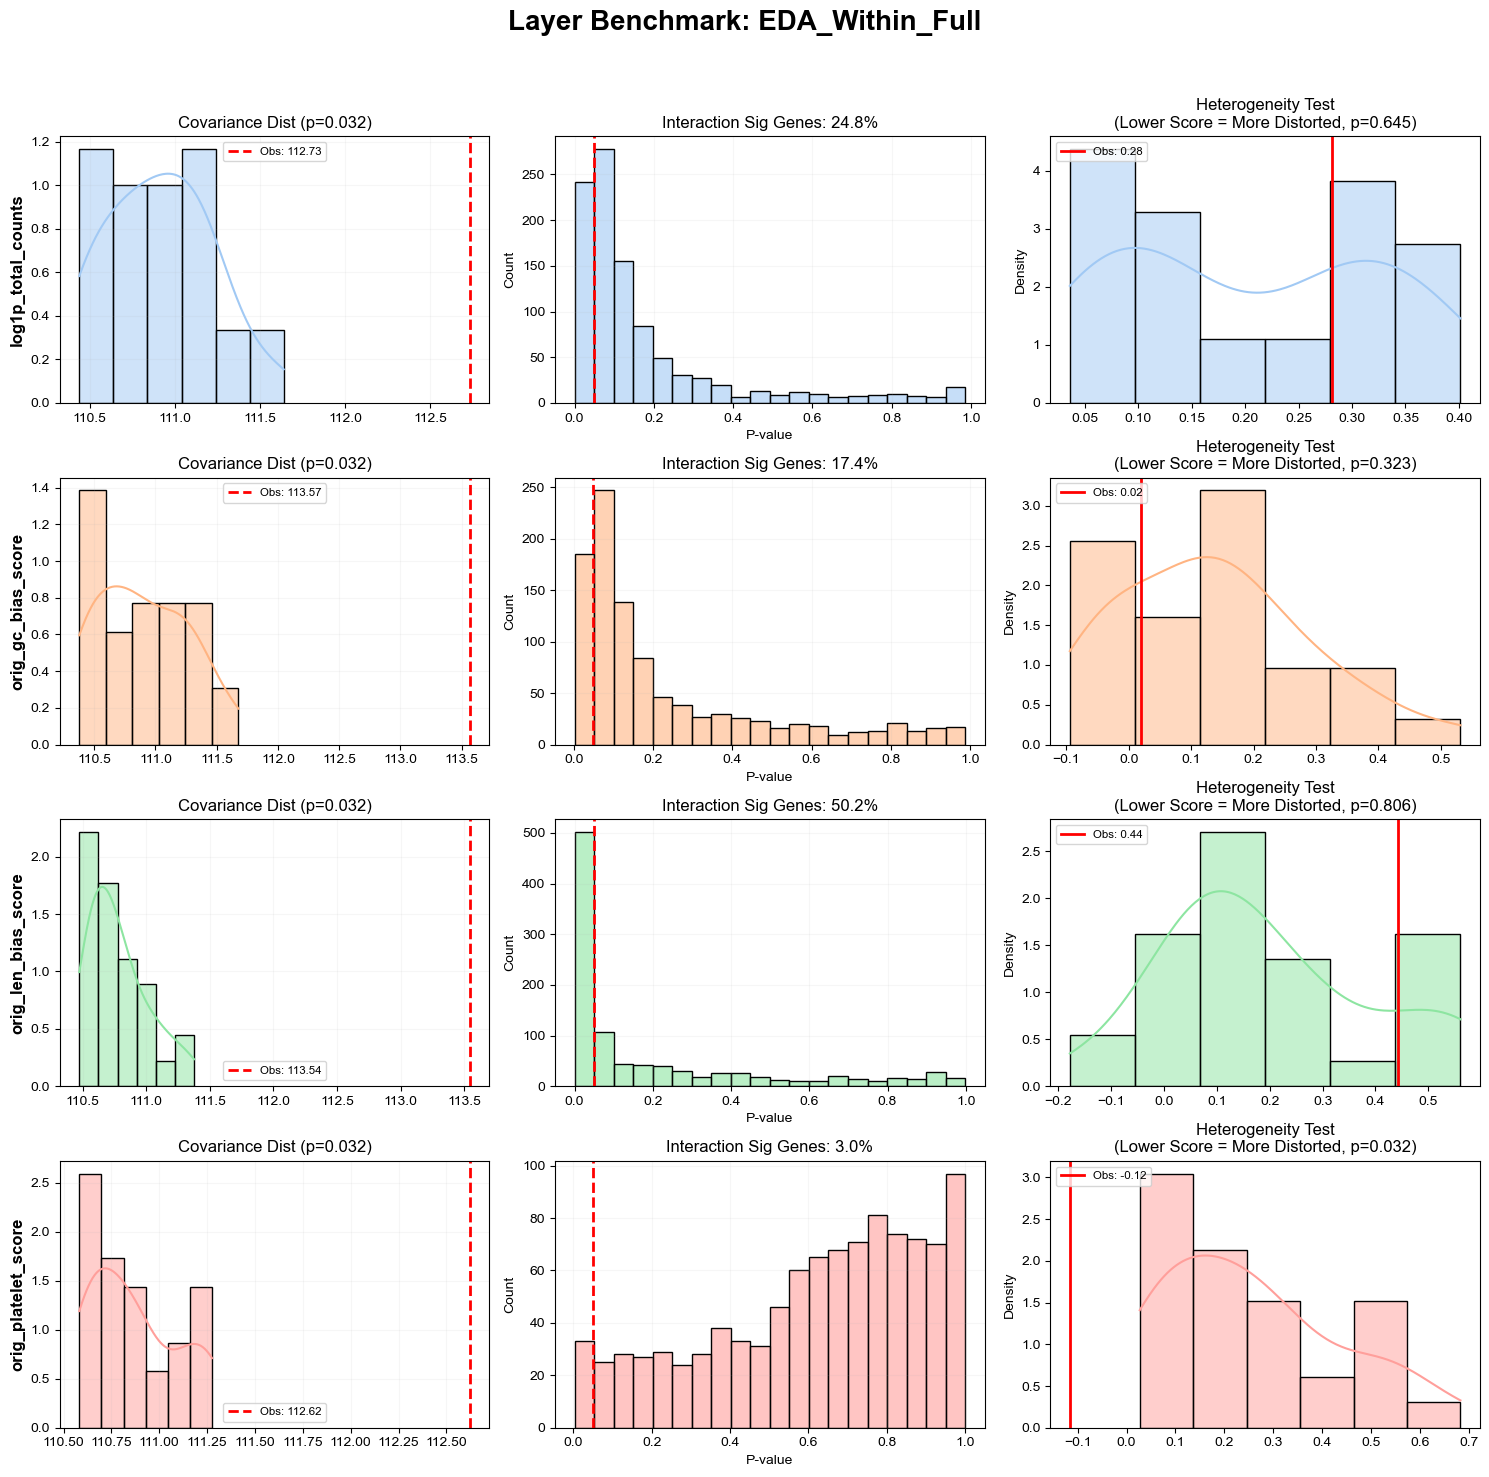

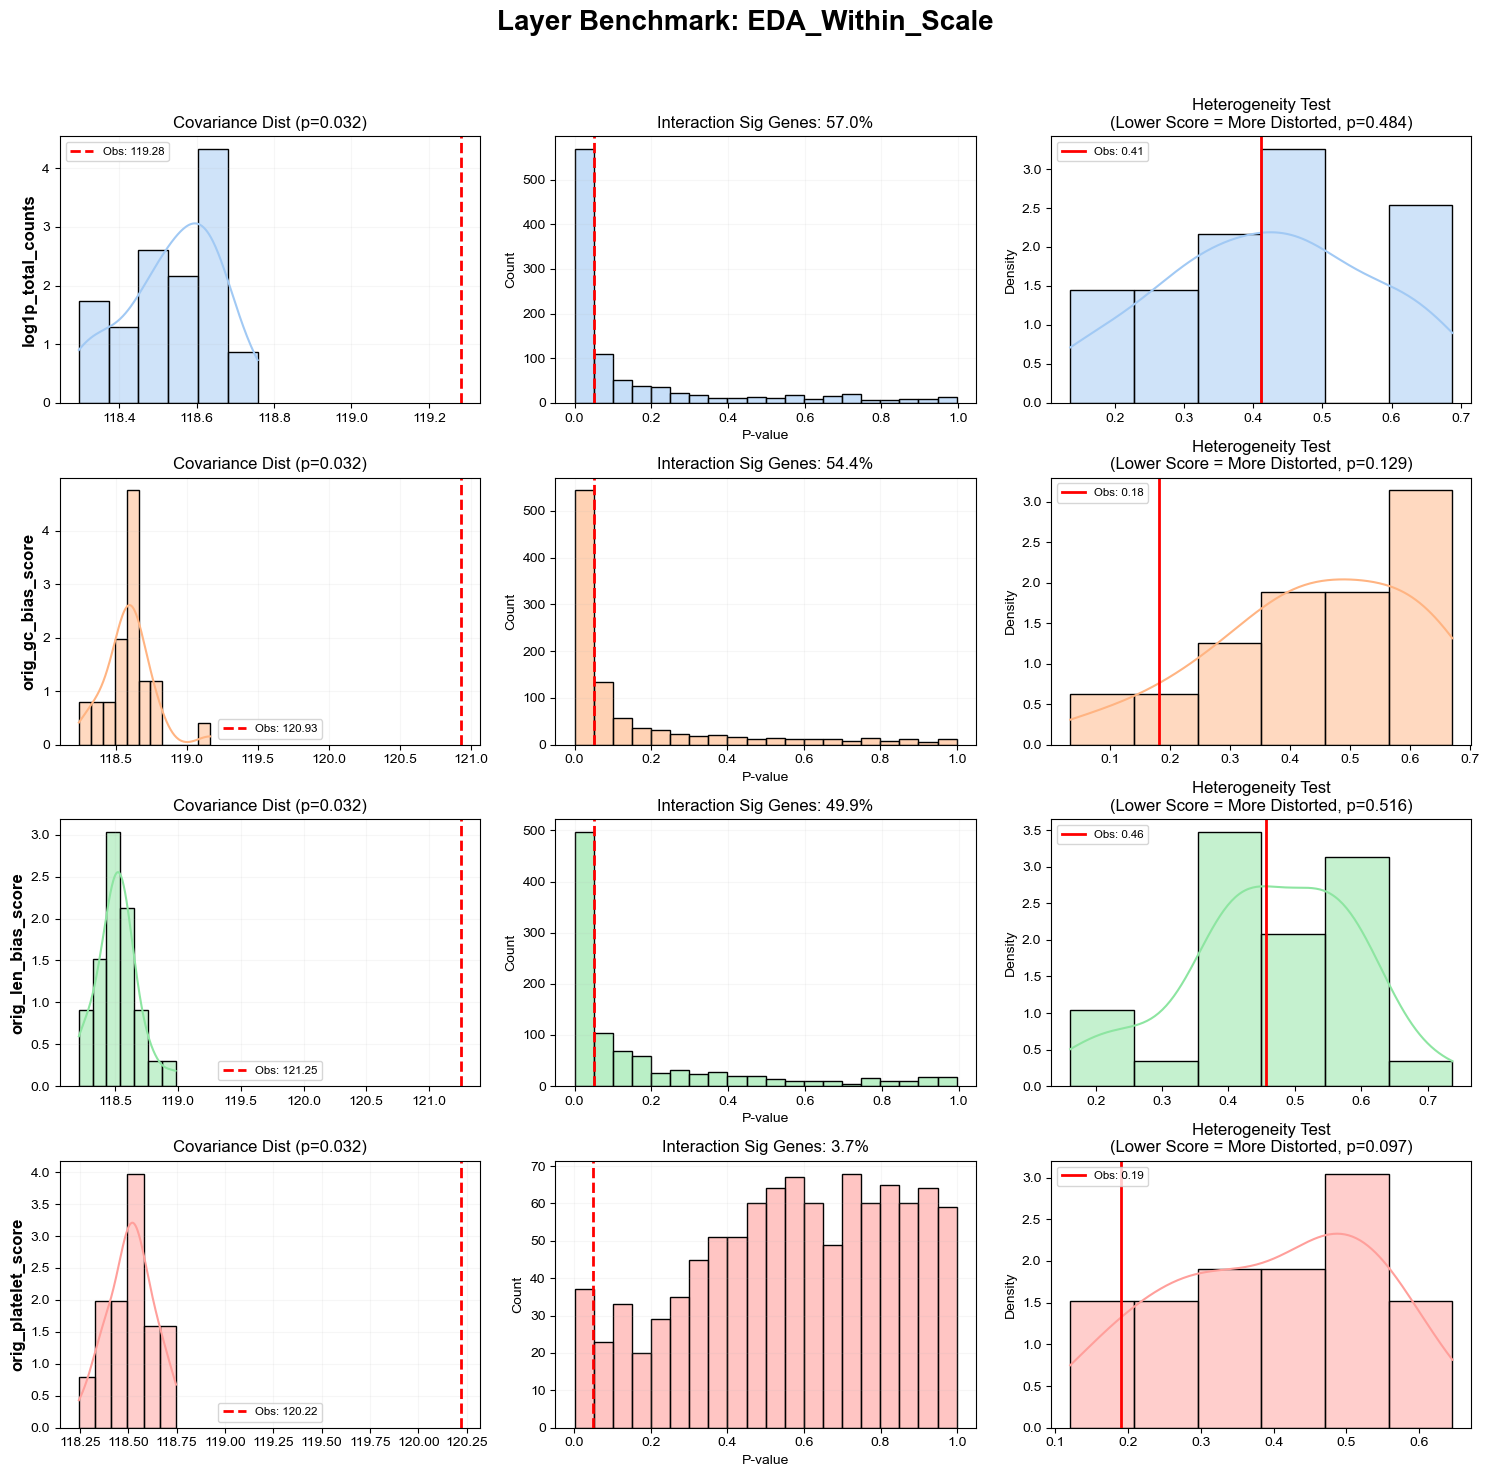

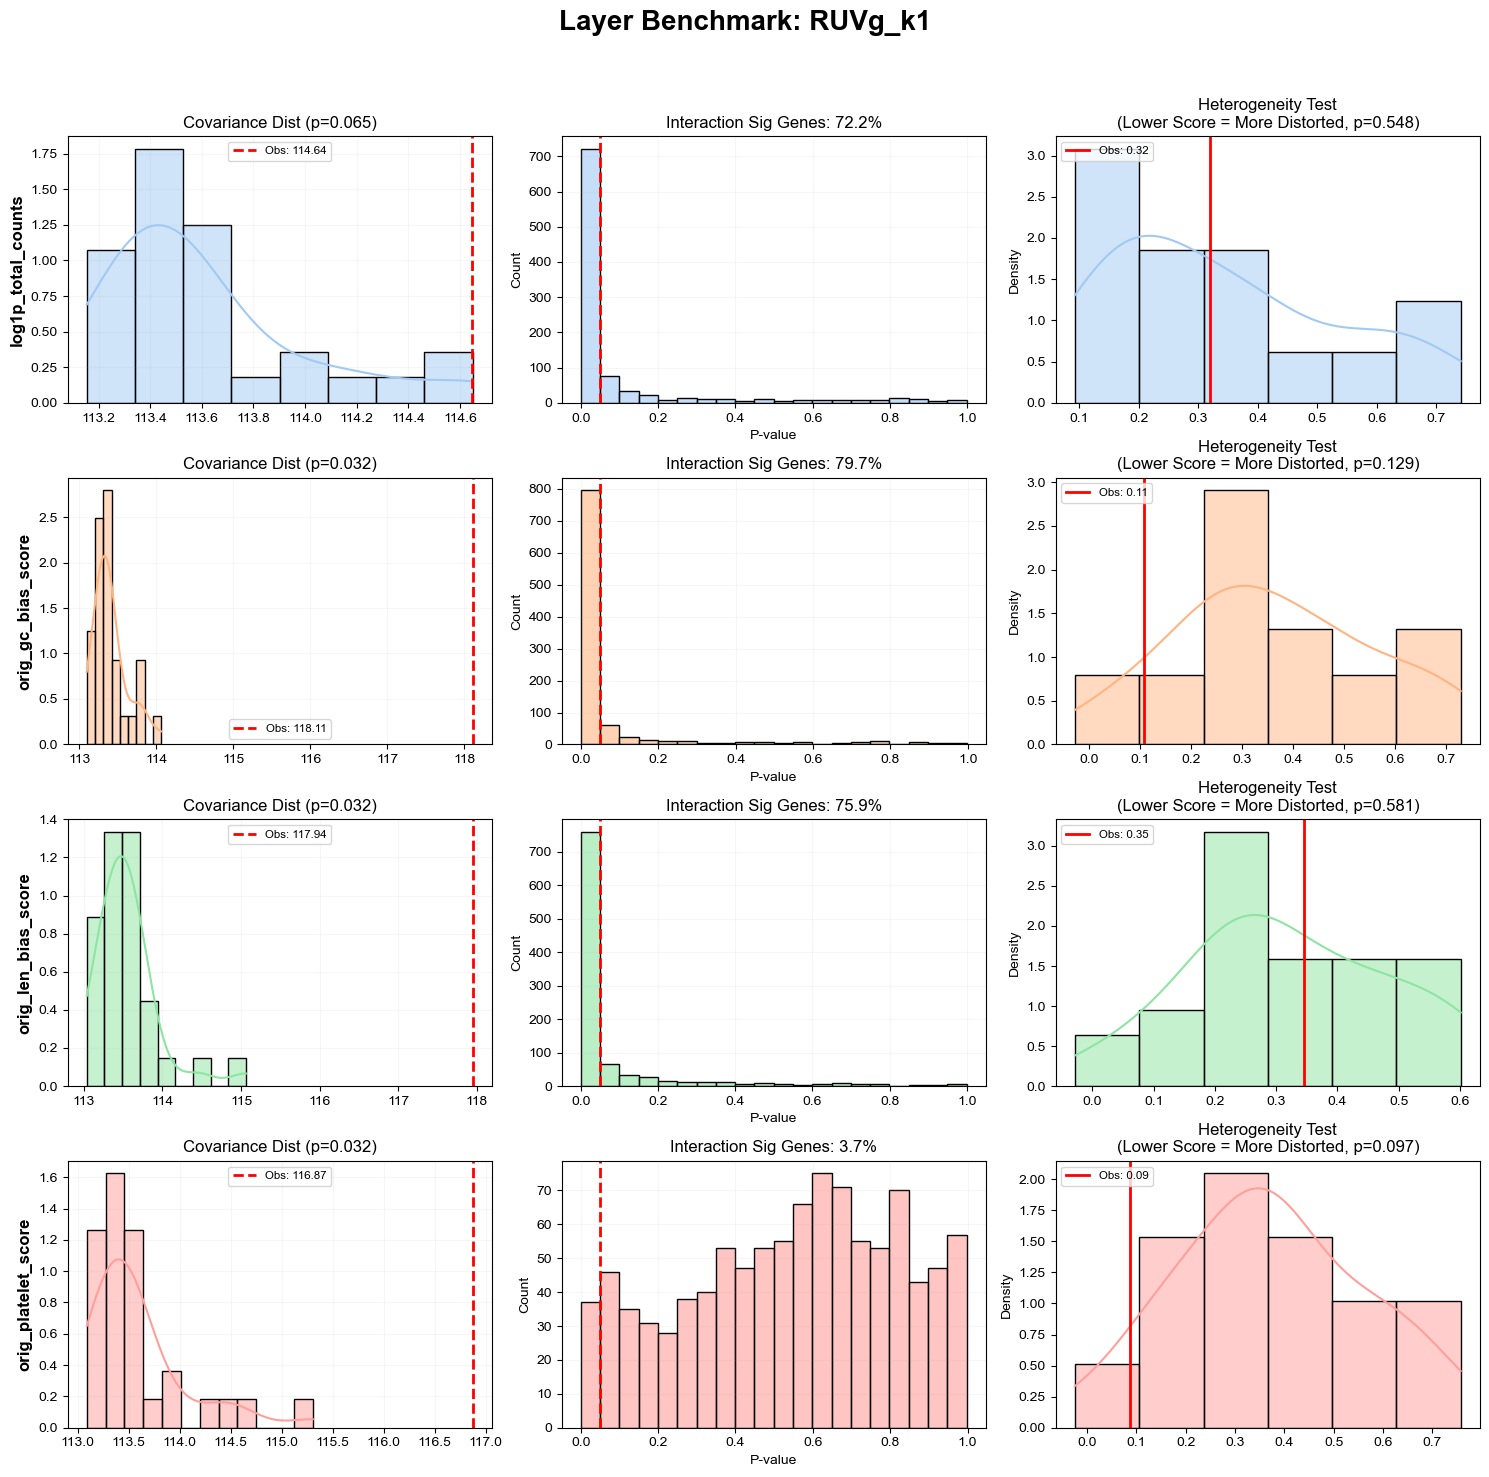

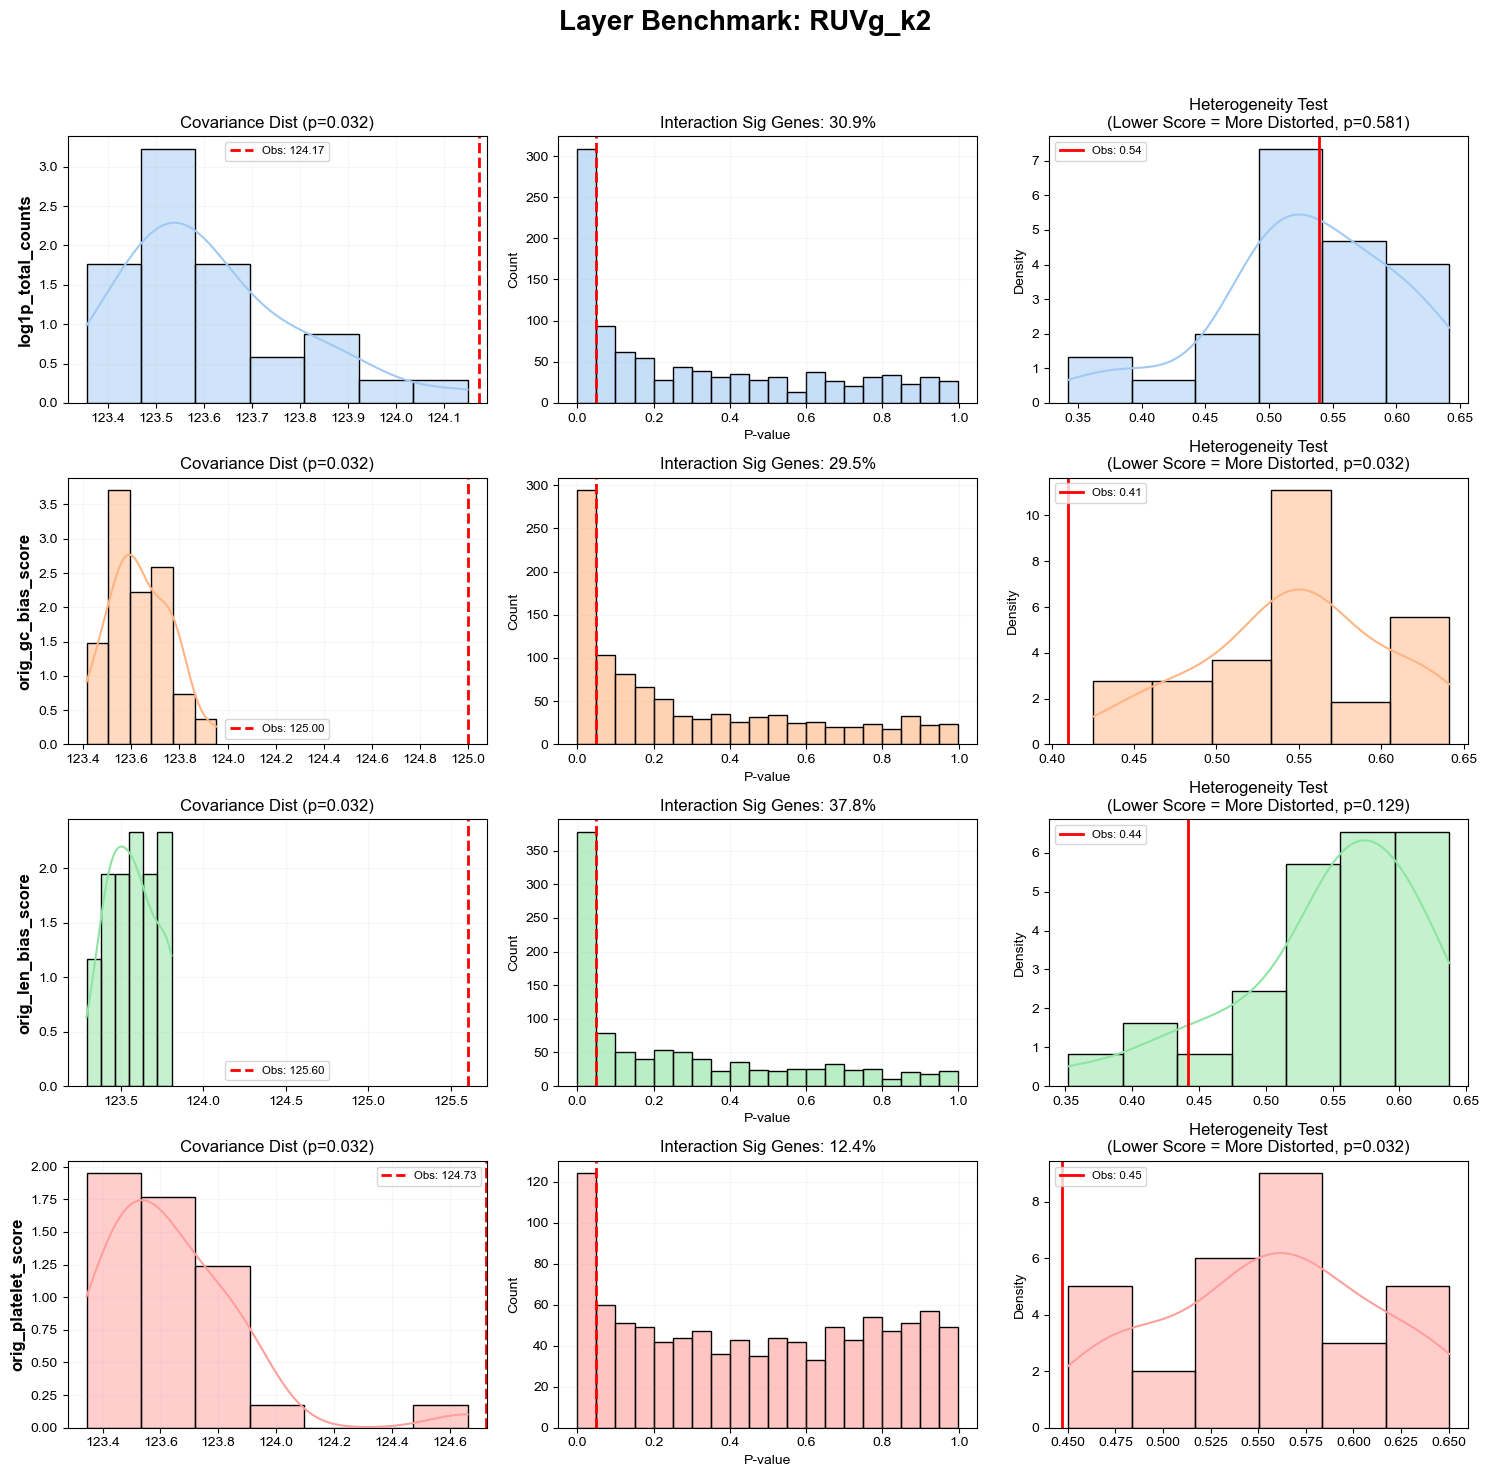

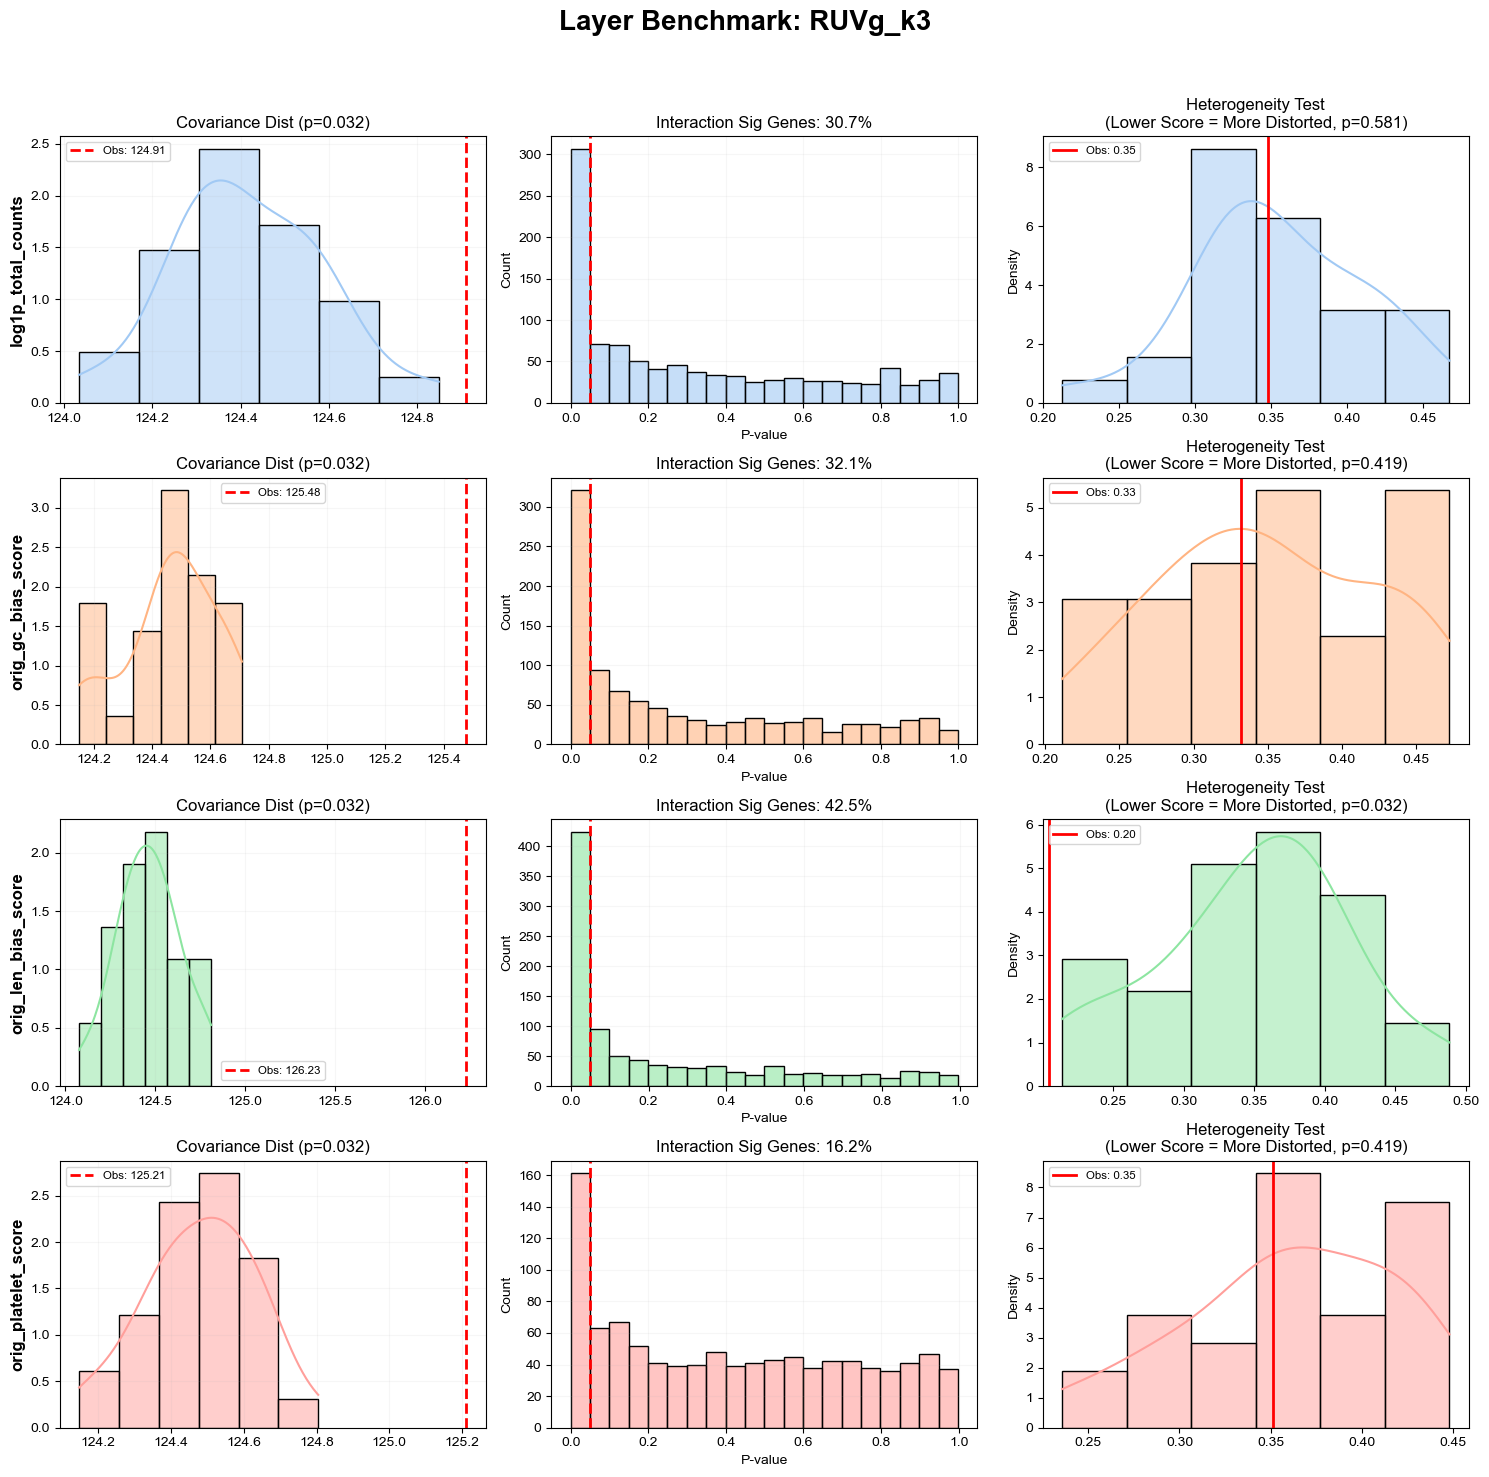

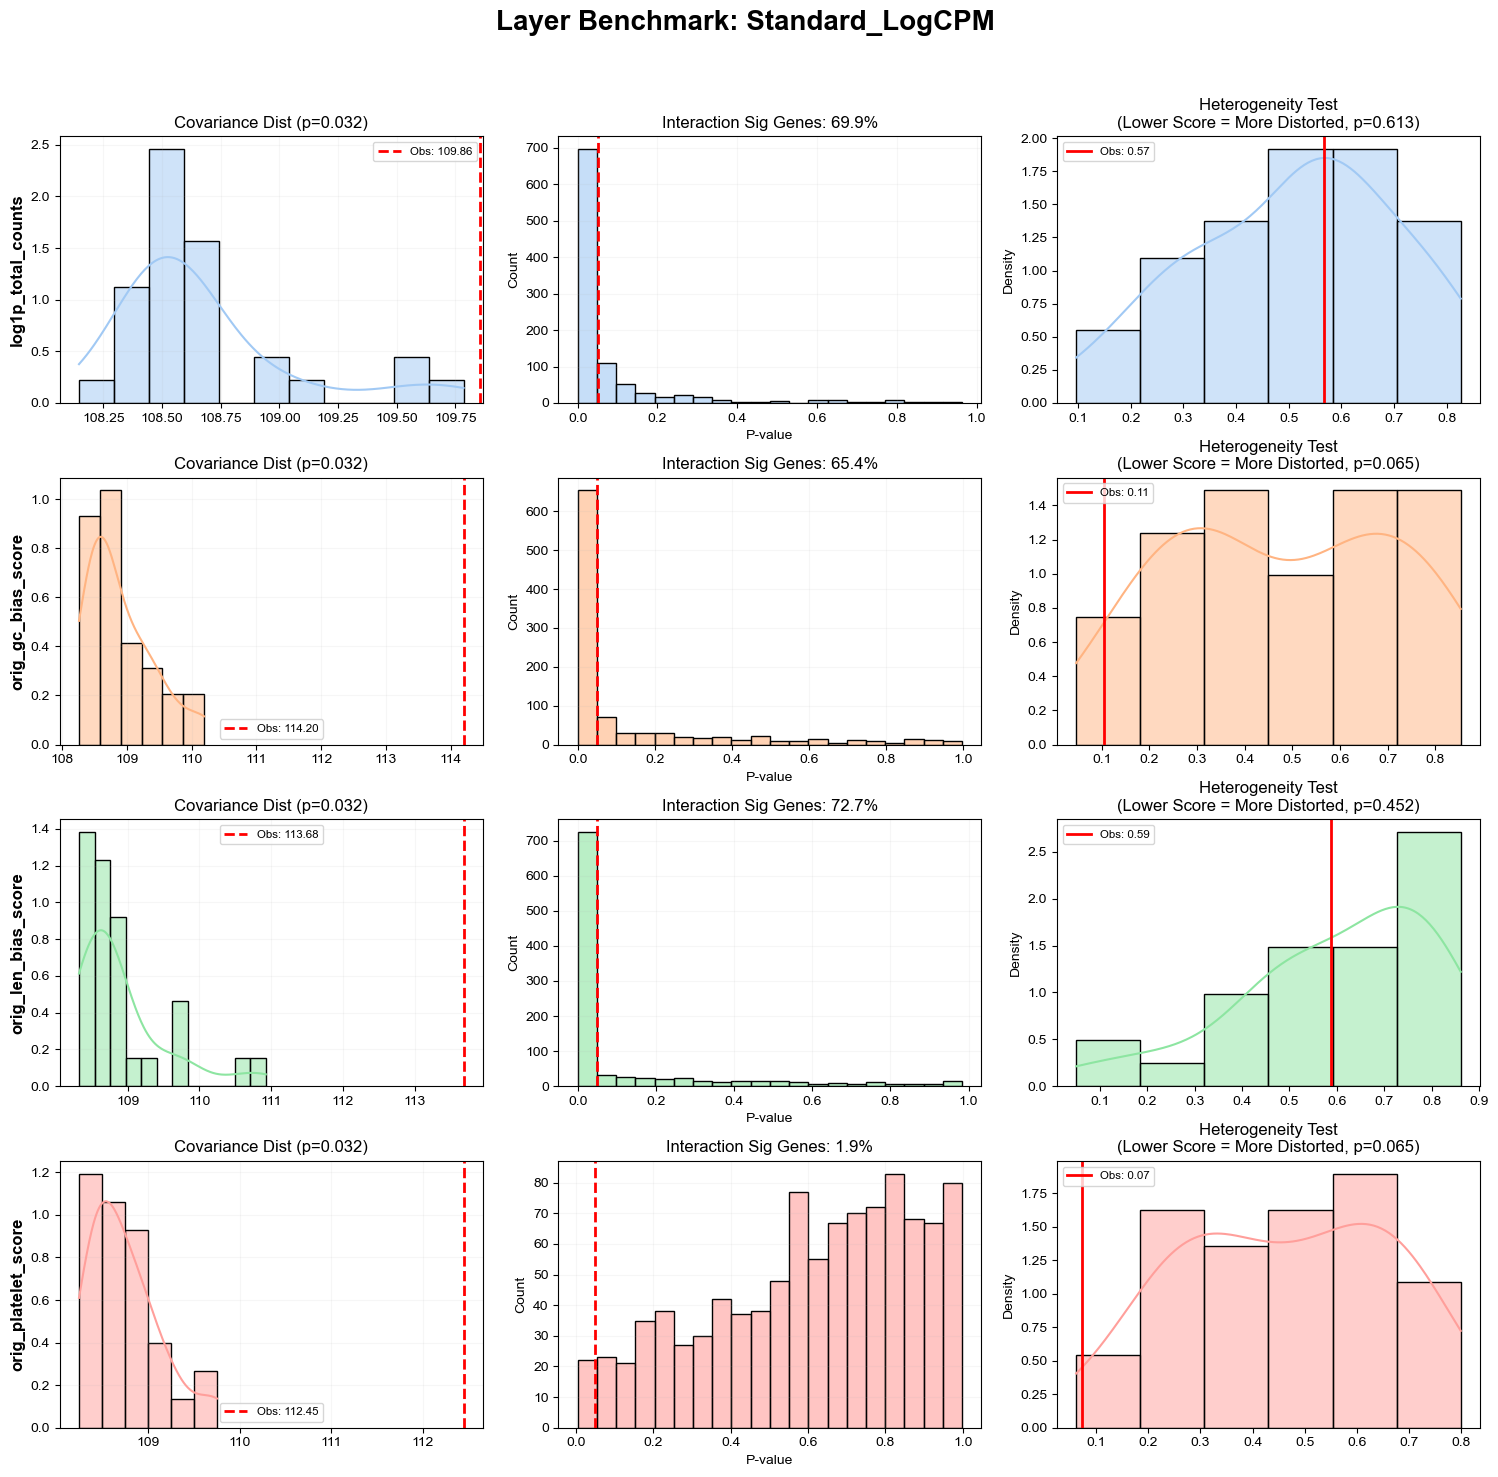

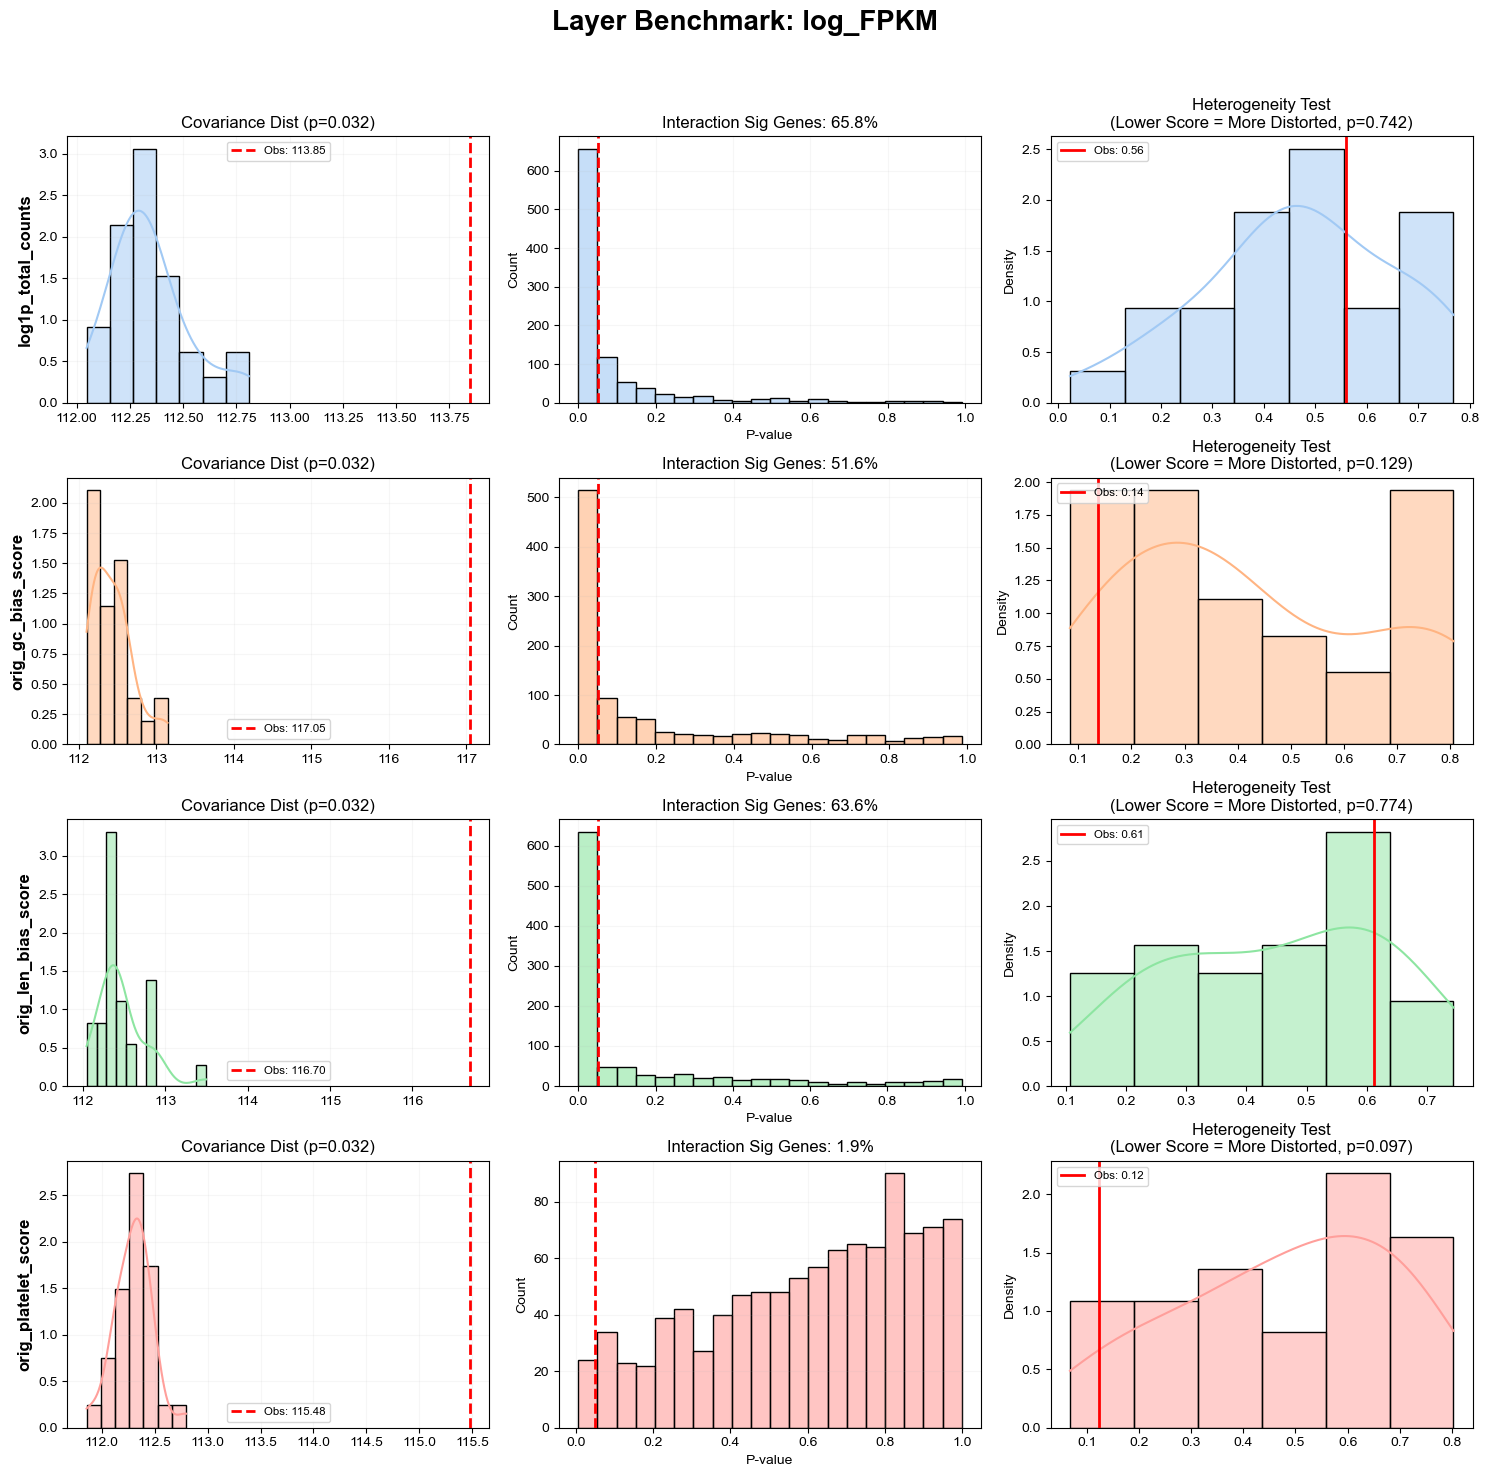

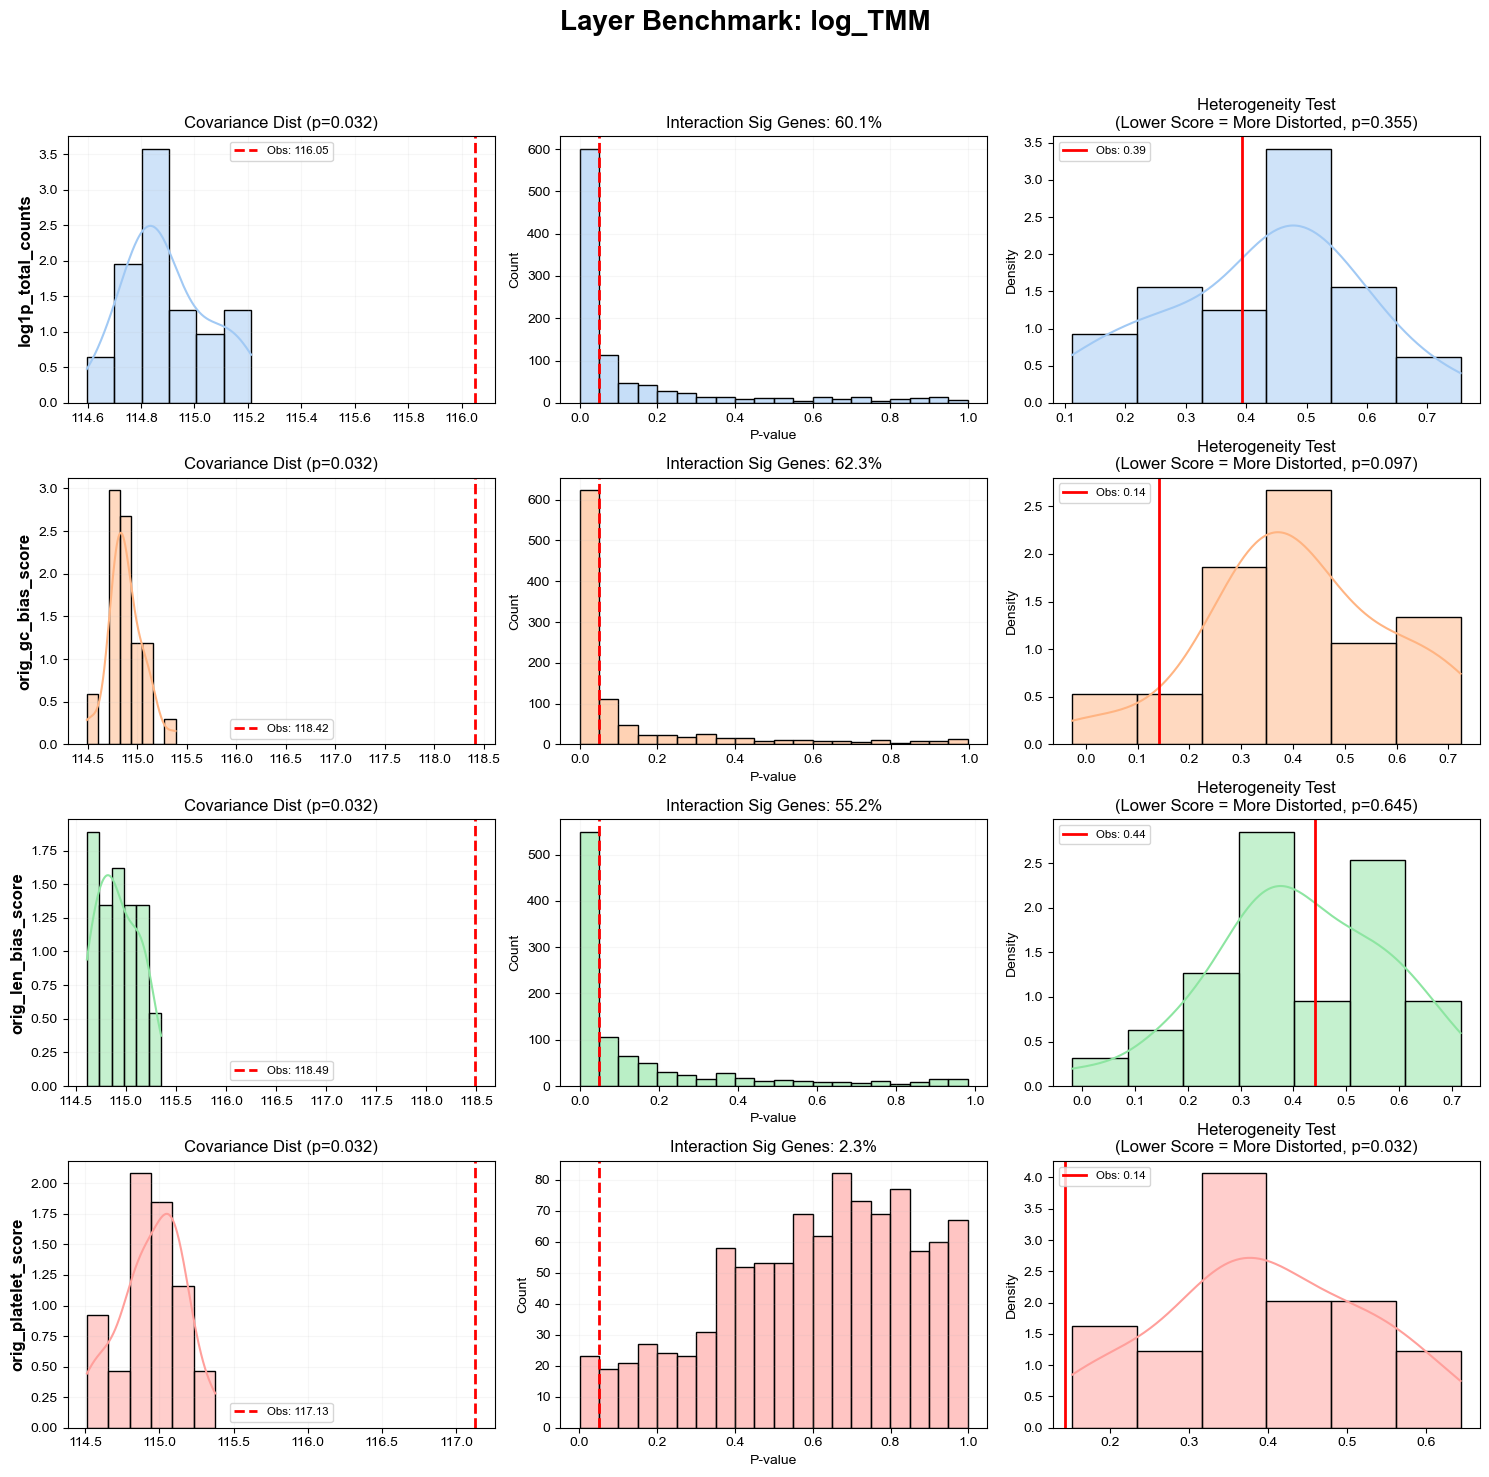

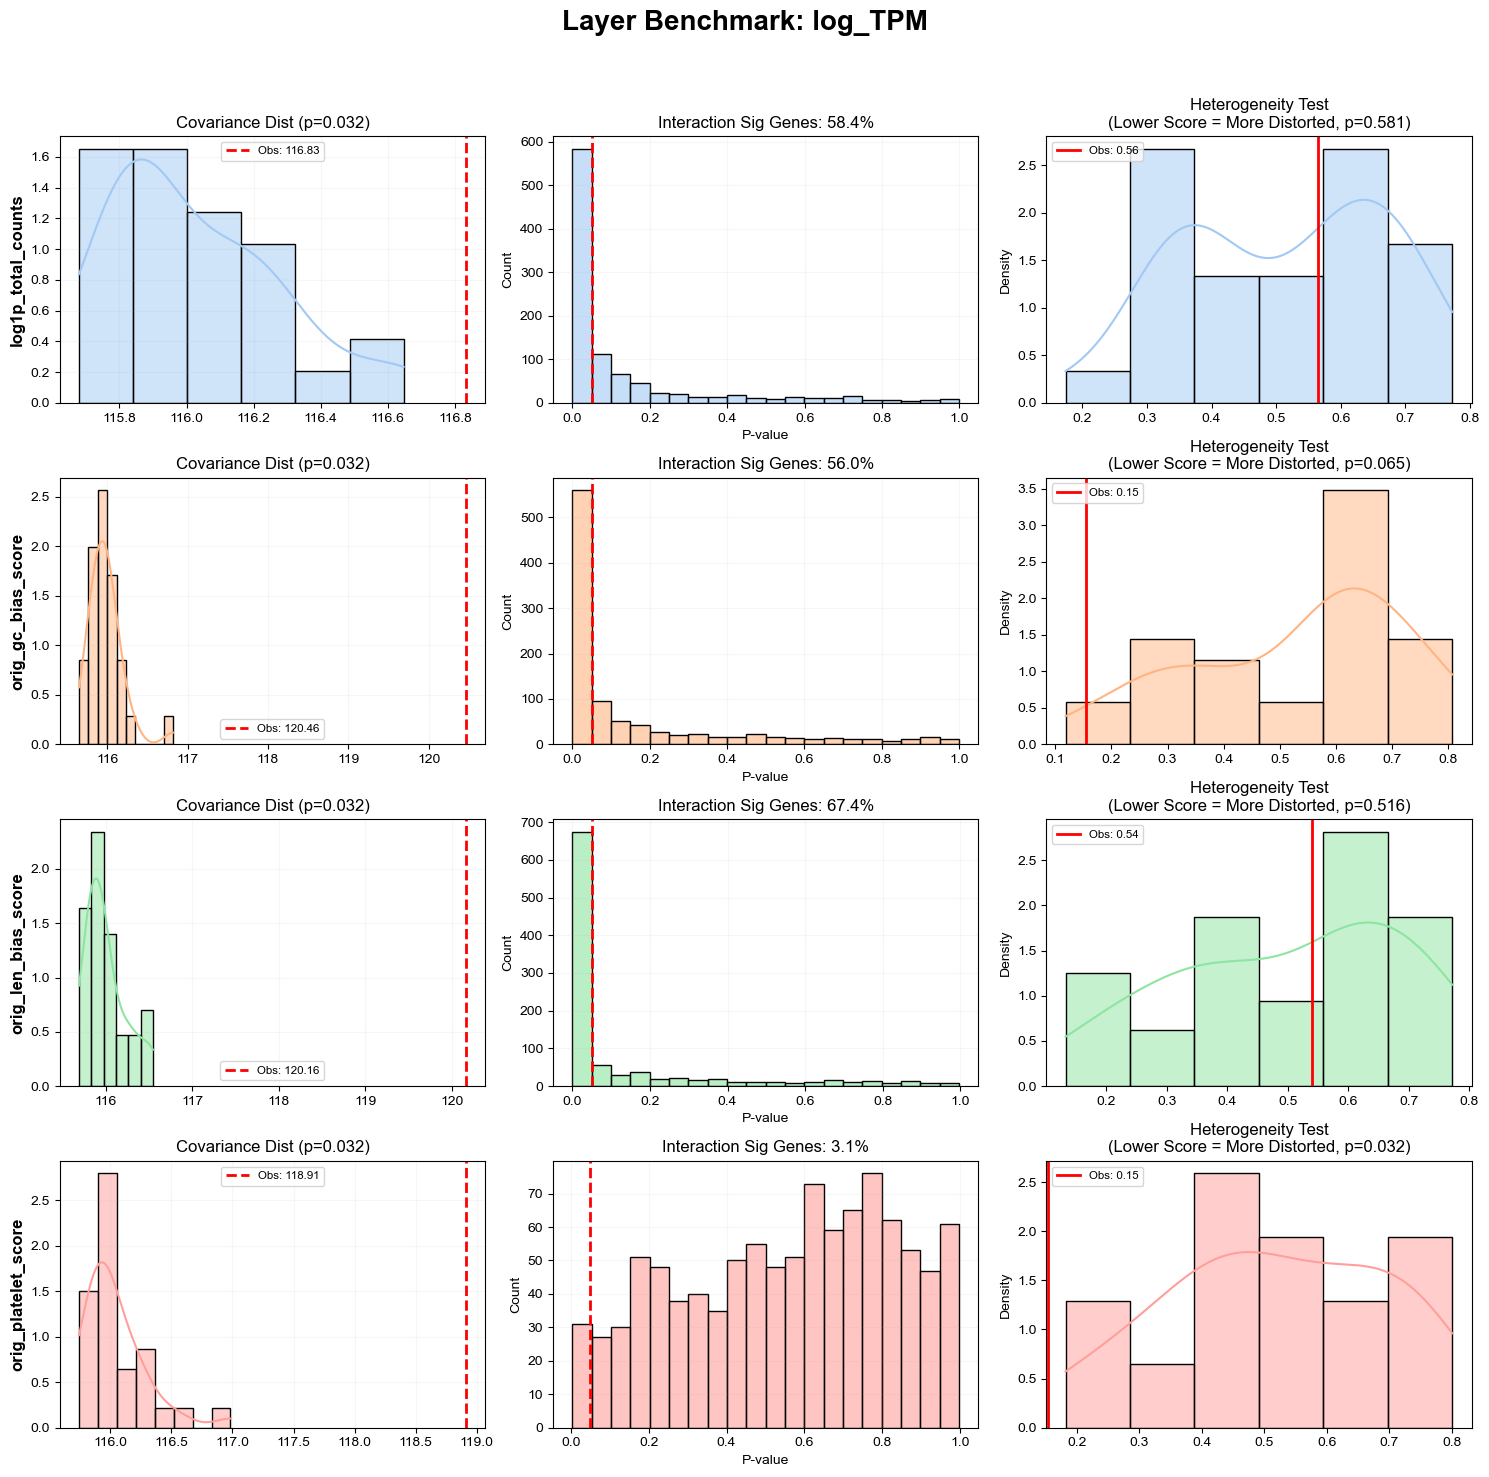


>>> Final Summary Head:


In [41]:
bias_colors = sns.color_palette("pastel", n_colors=len(bias_list))
all_results = []
print(f">>> Processing {len(layer_list)} Layers...")

for l_name in tqdm(layer_list, desc="Layers"):
    try:
        adata_ready = prepare_data(adata_sub, layer=l_name, n_hvg=1000)
    except Exception as e:
        print(f"Skipping {l_name}: {e}")
        continue
        
    fig, axes = plt.subplots(nrows=len(bias_list), ncols=3, figsize=(15, 4 * len(bias_list)))
    fig.suptitle(f"Layer Benchmark: {l_name}", fontsize=20, fontweight='bold', y=0.92)
    for i, b_name in enumerate(bias_list):
        current_color = bias_colors[i] 
        if b_name not in adata_sub.obs.columns:
            for j in range(3): axes[i, j].axis('off')
            continue
            
        try:
            # --- Col 1: Covariance ---
            cov_obs, cov_pval = analyze_covariance_structure(
                adata_ready, b_name, n_perms=30, ax=axes[i, 0], color=current_color
            )
            # Y축 라벨에 Bias 이름 크게 표시하여 가시성 확보
            axes[i, 0].set_ylabel(f"{b_name}", fontsize=12, fontweight='bold', color='black')
            
            # --- Col 2: Interaction ---
            inter_pct = analyze_interaction_distortion(
                adata_ready, b_name, phenotype, ax=axes[i, 1], color=current_color
            )
            
            # --- Col 3: Stability ---
            stab_obs, stab_pval = analyze_effect_stability(
                adata_ready, b_name, phenotype, n_perms=30, ax=axes[i, 2], color=current_color
            )
            
            # 결과 저장
            all_results.append({
                'Layer': l_name,
                'Bias': b_name,
                'Cov_Dist': cov_obs, 'Cov_Pval': cov_pval,
                'Inter_Sig_Pct': inter_pct,
                'Stab_Score': stab_obs, 'Stab_Pval': stab_pval
            })
            
        except Exception as e:
            print(f"Error ({l_name}, {b_name}): {e}")
            for j in range(3): axes[i, j].text(0.5, 0.5, "Error", ha='center')

    # 레이아웃 조정 및 출력
    plt.tight_layout(rect=[0, 0, 1, 0.9]) # suptitle 공간 확보
    plt.show()

# ====================================================
# [3] 최종 요약 DataFrame
# ====================================================
summary_df = pd.DataFrame(all_results)
print("\n>>> Final Summary Head:")

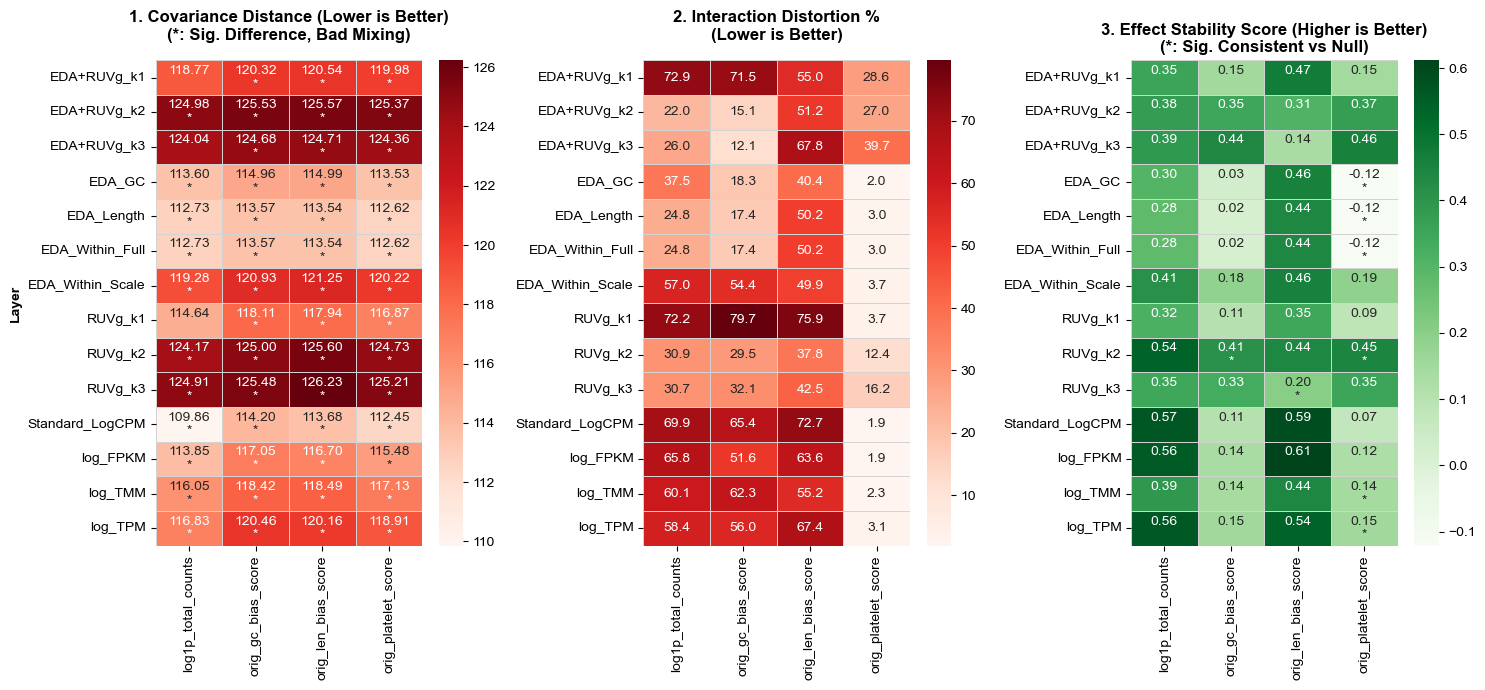

In [44]:
def plot_summary_heatmaps_with_stars(df):
    """
    summary_df를 입력받아 Heatmap을 그립니다.
    - Cov_Dist, Stab_Score: P-value에 따라 Asterisk(*) 표시
      (* < 0.05, ** < 0.01, *** < 0.001)
    - Inter_Sig_Pct: % 수치만 표시
    """
    if df.empty:
        print("Dataframe is empty.")
        return

    # 캔버스 설정
    fig, axes = plt.subplots(1, 3, figsize=(15, max(4, len(df['Layer'].unique()) * 0.5)))
    plt.subplots_adjust(wspace=0.3)

    # --- Helper: Asterisk 포맷팅 함수 ---
    def get_star_annotation(val_df, pval_df):
        annot_df = pd.DataFrame(index=val_df.index, columns=val_df.columns)
        for r in val_df.index:
            for c in val_df.columns:
                val = val_df.loc[r, c]
                p = pval_df.loc[r, c]
                if pd.isna(val) or pd.isna(p):
                    annot_df.loc[r, c] = ""
                    continue
                if p < 0.001: star = "***"
                elif p < 0.01: star = "**"
                elif p < 0.05: star = "*"
                else: star = ""
                annot_df.loc[r, c] = f"{val:.2f}\n{star}"
        return annot_df

    # =========================================================
    # 1. Covariance Distance (P-value 반영)
    # =========================================================
    # Pivot
    cov_val = df.pivot(index='Layer', columns='Bias', values='Cov_Dist')
    cov_pval = df.pivot(index='Layer', columns='Bias', values='Cov_Pval')
    
    # Annotation Matrix 생성
    cov_annot = get_star_annotation(cov_val, cov_pval)
    sns.heatmap(cov_val, annot=cov_annot, fmt="", cmap='Reds', 
                linewidths=0.5, linecolor='lightgray', ax=axes[0])
    
    axes[0].set_title("1. Covariance Distance (Lower is Better)\n(*: Sig. Difference, Bad Mixing)", 
                      fontsize=12, fontweight='bold', pad=15)
    
    axes[0].set_ylabel("Layer", fontweight='bold')
    inter_val = df.pivot(index='Layer', columns='Bias', values='Inter_Sig_Pct')
    
    sns.heatmap(inter_val, annot=True, fmt=".1f", cmap='Reds', 
                linewidths=0.5, linecolor='lightgray', ax=axes[1])
    axes[1].set_title("2. Interaction Distortion %\n(Lower is Better)", 
                      fontsize=12, fontweight='bold', pad=15)
    axes[1].set_ylabel("") # 중복 제거
    stab_val = df.pivot(index='Layer', columns='Bias', values='Stab_Score')
    stab_pval = df.pivot(index='Layer', columns='Bias', values='Stab_Pval')
    
    # Annotation Matrix 생성
    stab_annot = get_star_annotation(stab_val, stab_pval)
    
    sns.heatmap(stab_val, annot=stab_annot, fmt="", cmap='Greens', 
                linewidths=0.5, linecolor='lightgray', ax=axes[2])
    axes[2].set_title("3. Effect Stability Score (Higher is Better)\n(*: Sig. Consistent vs Null)", 
                      fontsize=12, fontweight='bold')
    axes[2].set_ylabel("")

    # 공통 설정
    for ax in axes:
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlabel("")
    plt.tight_layout()
    plt.show()

# --- 실행 ---
plot_summary_heatmaps_with_stars(summary_df)

## Bias-Label Relationship

In [53]:
adata = sc.read_h5ad("./Data/RPM/Processed/Complete_Normalized_Data.h5ad")
layer_list = list(adata.layers.keys())
layer_list.remove("counts")
bias_list = ['log1p_total_counts', 'orig_gc_bias_score', 'orig_len_bias_score', 'orig_platelet_score']
adata_sub = adata[(adata.obs['Seq_ID'] == 'RPMseq14')|(adata.obs['RPM_NC_label'].notna()), :]
phenotype = 'Type'

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def bias_label_relationship(df_meta, bias_list, condition_col):
    df_bias = df_meta[bias_list]
    valid_mask = df_bias.notna().all(axis=1)
    df_meta = df_meta[valid_mask]
    df_bias = df_bias[valid_mask]

    scaler = StandardScaler()
    X_bias_scaled = scaler.fit_transform(df_bias)
    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(X_bias_scaled).flatten()
    df_meta['Bias_Score'] = pc1
    loadings = pca.components_[0]
    print("\n[Bias PC1 Loadings]")
    for col, load in zip(bias_list, loadings):
        print(f" - {col}: {load:.3f}")
        
    groups = df_meta[condition_col].unique()
    try:
        groups = sorted(groups) # 가능하다면 정렬
    except:
        pass
    n_groups = len(groups)
    
    if n_groups < 2 :
        return()
    
    plt.figure(figsize=(1+n_groups, 6))
    sns.boxplot(data=df_meta, x=condition_col, y='Bias_Score', 
                order=groups, palette='Set2', width=0.5, showfliers=True)
    sns.swarmplot(data=df_meta, x=condition_col, y='Bias_Score', 
                  order=groups, color='black', alpha=0.5, s=4)
    y_max = df_meta['Bias_Score'].max()
    y_min = df_meta['Bias_Score'].min()
    y_range = y_max - y_min
    
    
    if n_groups == 2:
        g1 = df_meta[df_meta[condition_col] == groups[0]]['Bias_Score']
        g2 = df_meta[df_meta[condition_col] == groups[1]]['Bias_Score']
        
        stat, p_val = mannwhitneyu(g1, g2)
        print(f" - Mann-Whitney U Test: p-value = {p_val:.4e}")
        
        # 시각화: 브라켓 그리기
        x1, x2 = 0, 1
        y_h = y_max + y_range * 0.05
        plt.plot([x1, x1, x2, x2], [y_h, y_h + y_range*0.02, y_h + y_range*0.02, y_h], lw=1.5, c='k')
        
        significance = "ns"
        if p_val < 0.001: significance = "***"
        elif p_val < 0.01: significance = "**"
        elif p_val < 0.05: significance = "*"
            
        plt.text((x1+x2)*0.5, y_h + y_range*0.02, f"p={p_val:.3f}\n{significance}", 
                 ha='center', va='bottom', fontweight='bold')
        plt.title(f"Bias Score by {condition_col} (MWU Test)")

    # Case B: 3개 이상 그룹 (Kruskal-Wallis Test)
    elif n_groups > 2:
        group_data = [df_meta[df_meta[condition_col] == g]['Bias_Score'].values for g in groups]
        stat, p_val = kruskal(*group_data)
        print(f" - Kruskal-Wallis Test: p-value = {p_val:.4e}")
        
        significance = "Significant" if p_val < 0.05 else "Not Significant"
        plt.title(f"Bias Score by {condition_col}\n(Kruskal-Wallis p={p_val:.3e}, {significance})")

    else:
        plt.title(f"Bias Score Distribution (Single Group: {groups[0]})")

    plt.ylabel("Bias Composite Score (PC1)")
    plt.ylim(y_min - y_range*0.1, y_max + y_range*0.25) # 위쪽 여백 확보
    plt.grid(alpha=0.2)
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

In [112]:
obs = adata.obs.copy()

RPMseq10

[Bias PC1 Loadings]
 - log1p_total_counts: 0.485
 - orig_gc_bias_score: 0.519
 - orig_len_bias_score: -0.419
 - orig_platelet_score: 0.565
 - Kruskal-Wallis Test: p-value = 2.6124e-02


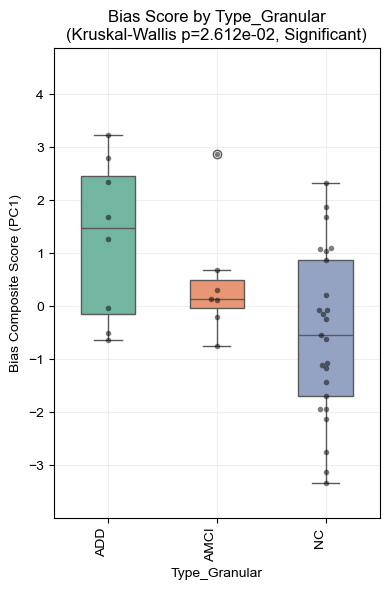

RPMseq14

[Bias PC1 Loadings]
 - log1p_total_counts: 0.547
 - orig_gc_bias_score: 0.575
 - orig_len_bias_score: -0.159
 - orig_platelet_score: 0.588
 - Mann-Whitney U Test: p-value = 5.9595e-03


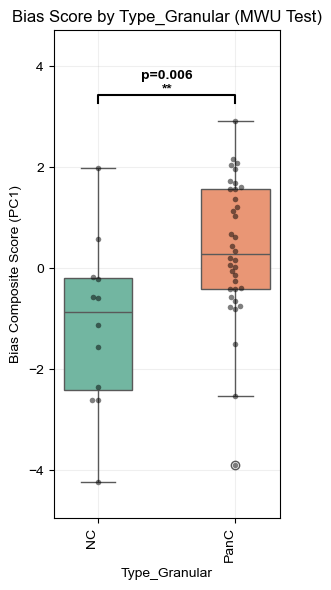

RPMseq12

[Bias PC1 Loadings]
 - log1p_total_counts: 0.527
 - orig_gc_bias_score: 0.524
 - orig_len_bias_score: -0.349
 - orig_platelet_score: 0.571
 - Kruskal-Wallis Test: p-value = 5.0941e-01


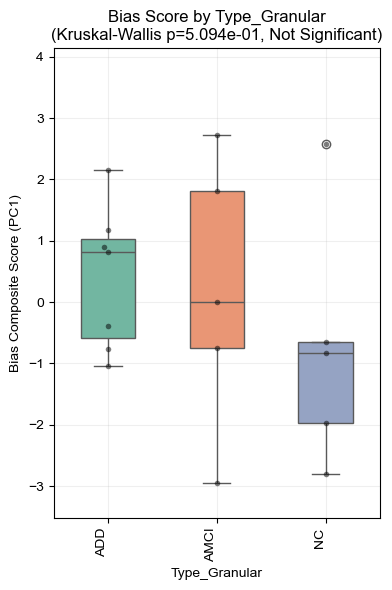

RPMseq13

[Bias PC1 Loadings]
 - log1p_total_counts: 0.530
 - orig_gc_bias_score: 0.456
 - orig_len_bias_score: -0.419
 - orig_platelet_score: 0.579
 - Kruskal-Wallis Test: p-value = 2.6767e-01


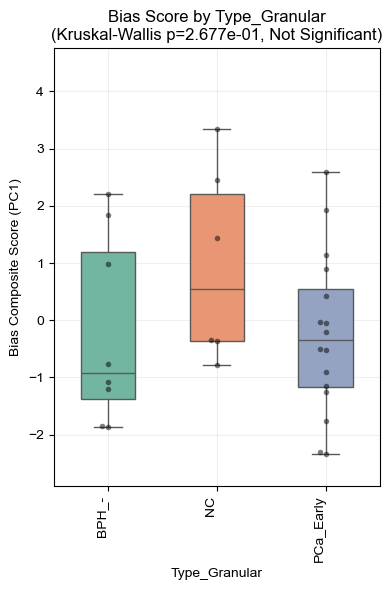

RPMseq16

[Bias PC1 Loadings]
 - log1p_total_counts: 0.533
 - orig_gc_bias_score: 0.598
 - orig_len_bias_score: -0.166
 - orig_platelet_score: 0.576
RPMseq15

[Bias PC1 Loadings]
 - log1p_total_counts: 0.533
 - orig_gc_bias_score: 0.546
 - orig_len_bias_score: 0.452
 - orig_platelet_score: 0.462
 - Kruskal-Wallis Test: p-value = 5.6795e-07


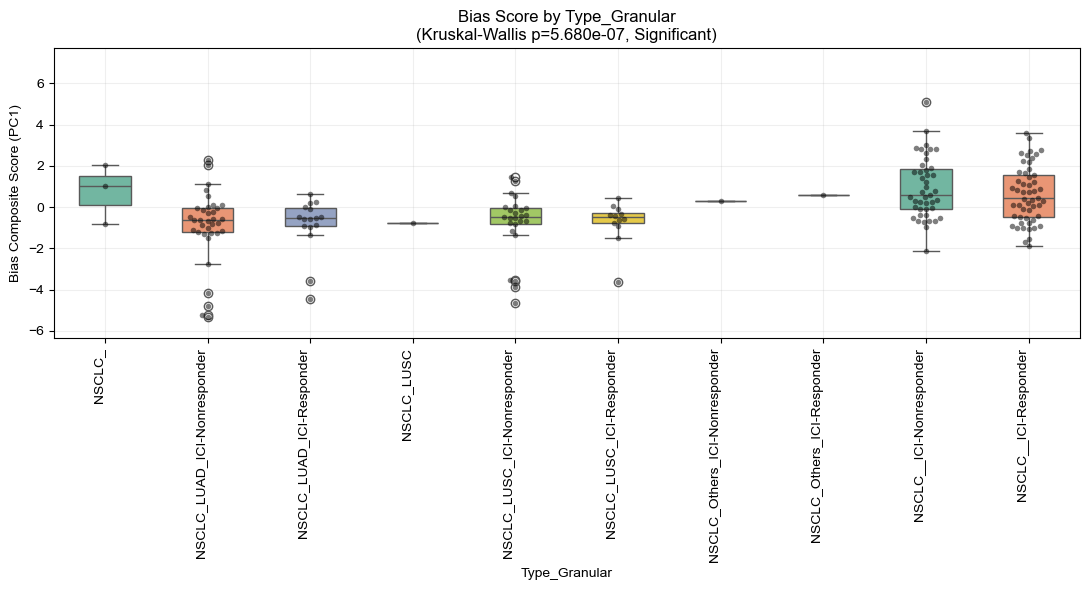

In [114]:
for seqid in obs['Seq_ID'].unique():
    print(seqid)
    try: 
        df_meta = obs.loc[obs['Seq_ID'] == seqid,:]
        bias_label_relationship(df_meta, bias_list, condition_col='Type_Granular')
    except :
        print("Skipped.", seqid)

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Metrics & Utils
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline

def check_bias_power_dist(df_meta, bias_list, condition_col, 
                          control_label='NC', task_type='binary'):
    """
    [기능]
    Bias 변수만으로 Label을 예측했을 때의 AUC 분포를 시각화.
    평균값뿐만 아니라 분포(Variance)를 보여주어 결과의 신뢰도를 높임.
    """
    
    # 1. 데이터 준비
    df_sub = df_meta[bias_list + [condition_col]].dropna().copy()
    
    if len(df_sub) < 15:
        print("[Error] 샘플 수가 너무 적습니다 (N < 15).")
        return

    X = df_sub[bias_list].values
    original_y = df_sub[condition_col].values

    # 2. 레이블 변환
    if task_type == 'binary':
        print(f"=== Bias Check [Binary]: {control_label} vs Others ===")
        y = np.where(original_y == control_label, 0, 1)
        classes = ['Control', 'Disease']
    else:
        print(f"=== Bias Check [Multiclass]: {np.unique(original_y)} ===")
        le = LabelEncoder()
        y = le.fit_transform(original_y)
        classes = le.classes_
        if len(classes) == 2:
            print("[Info] 클래스가 2개뿐이므로 Binary 로직으로 수행합니다.")
            task_type = 'binary'

    # 데이터 정보 출력
    unique, counts = np.unique(y, return_counts=True)
    print(f" - Data: N={len(y)} (Class dist: {dict(zip(unique, counts))})")
    print(f" - Features: {bias_list}")

    if np.min(counts) < 2:
        print("[Error] 특정 클래스 샘플 수 부족.")
        return

    # 3. 모델 정의 (SVC 추가됨)
    models = {
        'LogReg': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
        'SVM': make_pipeline(StandardScaler(), SVC(probability=True, kernel='rbf', random_state=42)), # AUC를 위해 probability=True 필수
        'RF': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
        'GBM': GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)
    }

    raw_results = [] # 모든 반복의 결과를 저장할 리스트
    
    # 4. 평가 (Repeated Split)
    n_repeats = 20
    sss = StratifiedShuffleSplit(n_splits=n_repeats, test_size=0.3, random_state=42)
    
    for name, model in models.items():
        for i, (train_ix, test_ix) in enumerate(sss.split(X, y)):
            X_train, X_test = X[train_ix], X[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            
            # 예외 처리: 테스트셋 클래스 누락 방지
            if task_type == 'multiclass':
                if len(np.unique(y_test)) < len(unique): continue 
            else:
                if len(np.unique(y_test)) < 2: continue

            try:
                model.fit(X_train, y_train)
                probs = model.predict_proba(X_test)
                
                if task_type == 'multiclass':
                    score = roc_auc_score(y_test, probs, multi_class='ovr', average='macro')
                else:
                    score = roc_auc_score(y_test, probs[:, 1])
                
                # [핵심 변경] 평균이 아니라 개별 기록 저장
                raw_results.append({
                    'Model': name,
                    'AUC': score,
                    'Iteration': i
                })
            except Exception as e:
                continue
    
    # 5. 시각화 (Boxplot + Strip)
    df_res = pd.DataFrame(raw_results)
    
    if df_res.empty:
        print("\n[Warning] 유효한 결과 없음.")
        return

    plt.figure(figsize=(5, 6))
    
    # 색상 팔레트 (SVC 포함 4개)
    my_pal = {'LogReg': '#A8D8EA', 'SVM': '#AA96DA', 'RF': '#FCBAD3', 'GBM': '#FFFFD2'}
    
    # Boxplot (분포)
    sns.boxplot(data=df_res, x='Model', y='AUC', palette=my_pal, 
                width=0.7, showfliers=False, linewidth=1.2)
    
    # Stripplot (개별 점 찍기) - 실제 데이터 포인트 보여주기
    sns.stripplot(data=df_res, x='Model', y='AUC', color='black', 
                  alpha=0.4, jitter=True, size=4)
    
    # 기준선
    plt.axhline(0.5, color='gray', linestyle='--', label='Random (0.5)')
    plt.axhline(0.7, color='red', linestyle=':', linewidth=2, label='Confounded (>0.7)')
    
    # 제목 및 스타일
    mode_title = "NC vs Disease" if task_type == 'binary' else "Multiclass (OVR)"
    plt.title(f"Bias Predictive Power Distribution\n[{mode_title}]", fontsize=13)
    plt.ylabel("AUC-ROC Score Distribution")
    plt.ylim(0, 1.1)
    plt.legend(loc='lower right', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 요약 통계 출력
    summary = df_res.groupby('Model')['AUC'].agg(['mean', 'std', 'min', 'max']).sort_values('mean', ascending=False)
    print("\n[Result Summary: Mean ± Std]")
    print(summary.round(3))


RPMseq10
=== Bias Check [Binary]: NC vs Others ===
 - Data: N=40 (Class dist: {np.int64(0): np.int64(25), np.int64(1): np.int64(15)})
 - Features: ['log1p_total_counts', 'orig_gc_bias_score', 'orig_len_bias_score', 'orig_platelet_score']


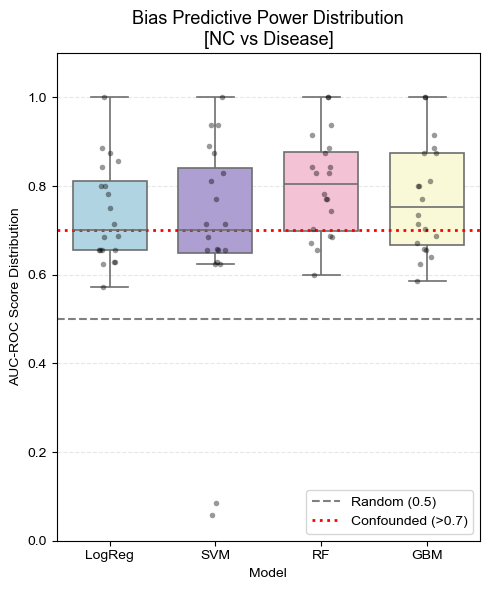


[Result Summary: Mean ± Std]
         mean    std    min  max
Model                           
RF      0.801  0.114  0.600  1.0
GBM     0.770  0.123  0.586  1.0
LogReg  0.738  0.113  0.571  1.0
SVM     0.691  0.243  0.057  1.0
RPMseq14
=== Bias Check [Binary]: NC vs Others ===
 - Data: N=48 (Class dist: {np.int64(0): np.int64(12), np.int64(1): np.int64(36)})
 - Features: ['log1p_total_counts', 'orig_gc_bias_score', 'orig_len_bias_score', 'orig_platelet_score']


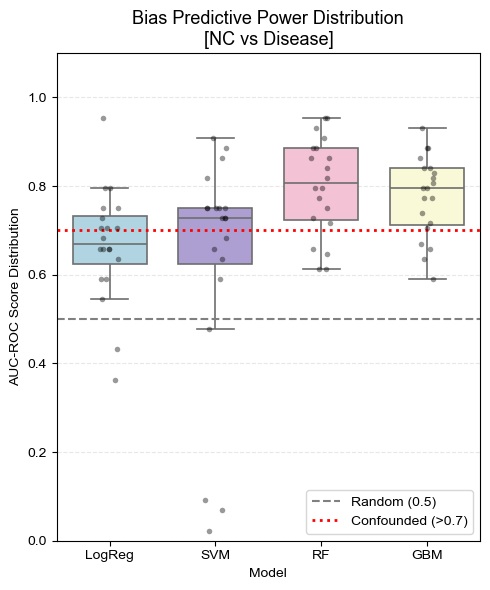


[Result Summary: Mean ± Std]
         mean    std    min    max
Model                             
RF      0.800  0.110  0.614  0.955
GBM     0.778  0.092  0.591  0.932
LogReg  0.668  0.128  0.364  0.955
SVM     0.632  0.265  0.023  0.909
RPMseq12
=== Bias Check [Binary]: NC vs Others ===
 - Data: N=17 (Class dist: {np.int64(0): np.int64(5), np.int64(1): np.int64(12)})
 - Features: ['log1p_total_counts', 'orig_gc_bias_score', 'orig_len_bias_score', 'orig_platelet_score']


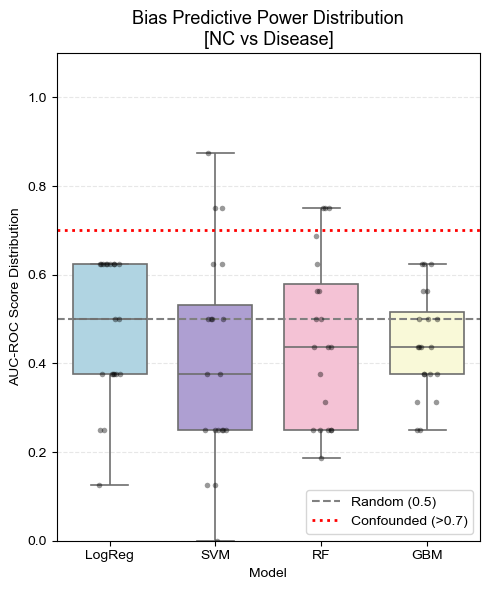

In [148]:
for seqid in obs['Seq_ID'].unique():
    print(seqid)
    df_meta = obs.loc[obs['Seq_ID'] == seqid,:]
    check_bias_power_dist(df_meta, bias_list, condition_col='Type_Granular')